In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

### Settings

This should be the config file you use

In [2]:
# cancerTypeDetailed or cancerType
analysis_type = 'cancerTypeDetailed'

In [3]:
config = "../global_config_bash.rc"

In [4]:
with open(config, 'r') as f :
    bash_script_content = f.read()
    lines = bash_script_content.splitlines()
paths = {}
for line in lines:
    line = line.strip()
    if line and '=' in line:
        key, value = line.split('=', 1)
        key = key.strip()
        value = value.strip()
        # Handle variable references
        while '${' in value:
            start_index = value.find('${')
            end_index = value.find('}', start_index)
            if start_index != -1 and end_index != -1:
                variable_name = value[start_index + 2:end_index]
                if variable_name in paths:
                    value = value[:start_index] + paths[variable_name] + value[end_index + 1:]
                else:
                    break  # Stop if variable reference not found
        paths[key] = value.strip('"\'')  # Remove surrounding quotes if any

In [5]:
# Merged ECHO results
echo = pd.read_csv(paths['mergedOutputDirectory'] + '/merged.ECHO_results.csv')
# Merged FACETS cbioportal file
manifest = pd.read_csv(paths['mergedOutputDirectory'] + '/facets_cbioportal_merged_full.tsv', sep = '\t')

In [6]:
# Merged FACETS results
facets = pd.read_csv(paths['mergedOutputDirectory'] + '/merged.FACETS_gene_results.tsv', sep = '\t')

### Clean Up Dataframe

In [7]:
echo['patientId'] = echo['sample_id'].apply(lambda x: x.split('-', 2)[0] + '-' + x.split('-', 2)[1])
echo['tumorSampleId'] = echo['sample_id'].apply(lambda x: '-'.join(x.split('-', 4)[:4]))
echo['normalSampleId'] = echo.apply(lambda row: row['sample_id'][len(row['tumorSampleId']):].lstrip('-'), axis = 1)
echo.drop('sample_id', axis = 1, inplace = True)
echo = echo[['patientId', 'tumorSampleId', 'normalSampleId', 'chromosome', 'gene', 'log2', 'cn','ecDNA_prob', 'ecDNA_status']]

In [8]:
manifest['sampleId'] = manifest['ID']
manifest = manifest[['sampleId', 'cancerType', 'cancerTypeDetailed', 'osStatus', 'osMonths']]
echo = pd.merge(echo, manifest, left_on = 'tumorSampleId', right_on = 'sampleId', how = 'left')

Add facets results to echo

In [9]:
facets_cn_dict = {}
facets_amp_dict = {}

for i, row in facets.iterrows() :
    if row['gene'] != 'No_genes_above_ECHO_amplification_threshold' :
        to_hash = row['sample'] + '_' + row['gene']
        facets_cn_dict[to_hash] = float(row['tcn'])
        facets_amp_dict[to_hash] = row['cn_state']

echo['facets_cn'] = np.nan
echo['facets_amp'] = ''
echo['facets_amp_binary'] = "No Amp"

for i, row in echo.iterrows() :
    if isinstance(row['gene'], str) :
        to_hash = row['tumorSampleId'] + '_' + row['gene']
        if to_hash in facets_cn_dict :
            echo.loc[i, 'facets_cn'] = facets_cn_dict[to_hash]
        if to_hash in facets_amp_dict :
            echo.loc[i, 'facets_amp'] = facets_amp_dict[to_hash]
            if isinstance(facets_amp_dict[to_hash], str) :
                if "AMP" in facets_amp_dict[to_hash] or "GAIN" in facets_amp_dict[to_hash] :
                    echo.loc[i, 'facets_amp_binary'] = "Amp"

Get a dictionary specific to each patient

In [10]:
# This tracks all genes with ecDNA, separated by _
ecDNA_per_patient = {}
for idx, row in echo.iterrows() :
    if row['patientId'] not in ecDNA_per_patient :
        ecDNA_per_patient[row['patientId']] = ''
    if row['ecDNA_status'] == 'ecDNA' :
        if ecDNA_per_patient[row['patientId']] == '' :
            ecDNA_per_patient[row['patientId']] = row['gene']
        else :
            ecDNA_per_patient[row['patientId']] += '_' + row['gene']

Create dataframe per patient

In [11]:
patientsList = echo['patientId'].unique()

# Tracks ecDNA status and takes the data from above
ecDNA_patient = pd.DataFrame(patientsList, columns = ['patientId'])
ecDNA_patient['ecDNAStatus'] = None
ecDNA_patient['ecDNAList'] = ''

for idx, row in ecDNA_patient.iterrows() :
    ecDNA_patient.loc[idx, 'ecDNAList'] = ecDNA_per_patient[row['patientId']]
    if ecDNA_per_patient[row['patientId']] == '' :
        ecDNA_patient.loc[idx, 'ecDNAStatus'] = False
    else :
        ecDNA_patient.loc[idx, 'ecDNAStatus'] = True


Add copy number (taking the largest copy number)

In [12]:
# Not necessary right now. If you want to use max copy number as a covariate
max_copy_number = {}
for idx, row in echo.iterrows() :
    if row['patientId'] in max_copy_number :
        max_copy_number[row['patientId']] = max(max_copy_number[row['patientId']], row['cn'])
    else :
        max_copy_number[row['patientId']] = row['cn']

ecDNA_patient['max_cn'] = np.nan
for idx, row in ecDNA_patient.iterrows() :
    ecDNA_patient.loc[idx, 'max_cn'] = max_copy_number[row['patientId']]


### Basic Plots

Comparing copy numbers

Text(0, 0.5, 'FACETS cn')

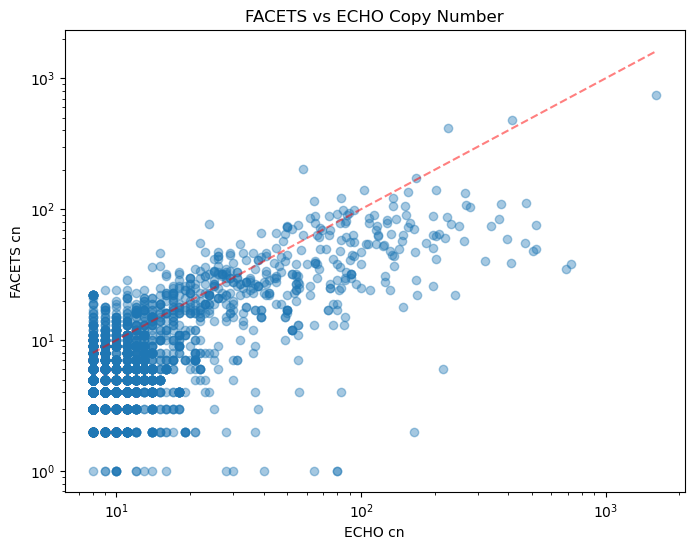

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(echo['cn'], echo['facets_cn'], alpha = 0.4)
plt.yscale('log')
plt.xscale('log')
plt.title("FACETS vs ECHO Copy Number")
x_values = np.arange(max(echo['cn'].min(), echo['facets_cn'].min()), max(echo['cn'].max(), echo['facets_cn'].max()))

plt.plot(x_values, x_values, color = 'red', linestyle = '--', label = 'y=x', alpha = 0.5)
plt.xlabel('ECHO cn')
plt.ylabel('FACETS cn')

ECHO copy number vs ecDNA call

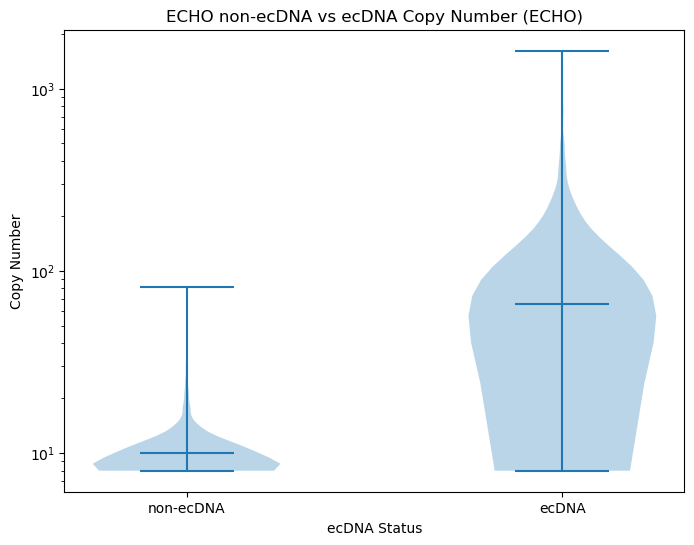

In [14]:
# Plotting violin plot
plt.figure(figsize=(8, 6))
plt.violinplot(dataset=[echo[echo['ecDNA_status'] == 'non-ecDNA']['cn'], 
                        echo[echo['ecDNA_status'] == 'ecDNA']['cn']],
               showmeans=False, showmedians=True)
plt.title('ECHO non-ecDNA vs ecDNA Copy Number (ECHO)')
plt.xticks([1, 2], ['non-ecDNA', 'ecDNA']) 
plt.ylabel('Copy Number')
plt.xlabel("ecDNA Status")
plt.yscale('log')
plt.show()

FACETS copy number version

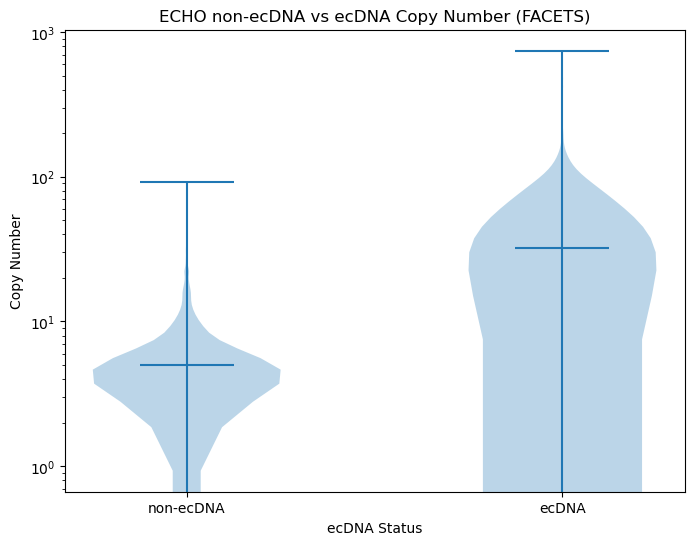

In [15]:
# Plotting violin plot
plt.figure(figsize=(8, 6))
plt.violinplot(dataset=[echo.loc[(echo['ecDNA_status'] != 'ecDNA') & (~echo['facets_cn'].isna()), 'facets_cn'], 
                        echo.loc[(echo['ecDNA_status'] == 'ecDNA') & (~echo['facets_cn'].isna()), 'facets_cn']],
               showmeans=False, showmedians=True)
plt.title('ECHO non-ecDNA vs ecDNA Copy Number (FACETS)')
plt.xticks([1, 2], ['non-ecDNA', 'ecDNA']) 
plt.ylabel('Copy Number')
plt.xlabel("ecDNA Status")
plt.yscale('log')
plt.show()

Text(0.5, 1.0, 'ecDNA Probability vs ECHO Copy Number')

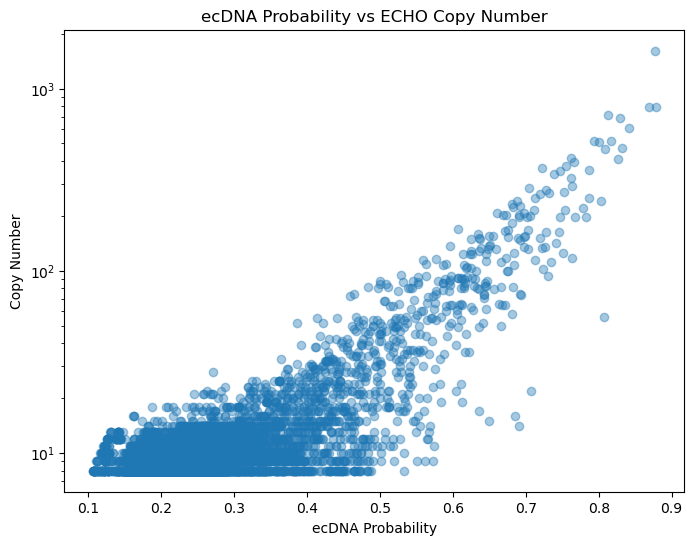

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(echo['ecDNA_prob'], echo['cn'], alpha=0.4)
plt.ylabel("Copy Number")
plt.xlabel("ecDNA Probability")
plt.yscale('log')
plt.title("ecDNA Probability vs ECHO Copy Number")


Text(0.5, 1.0, 'ecDNA Probability vs FACETS Copy Number')

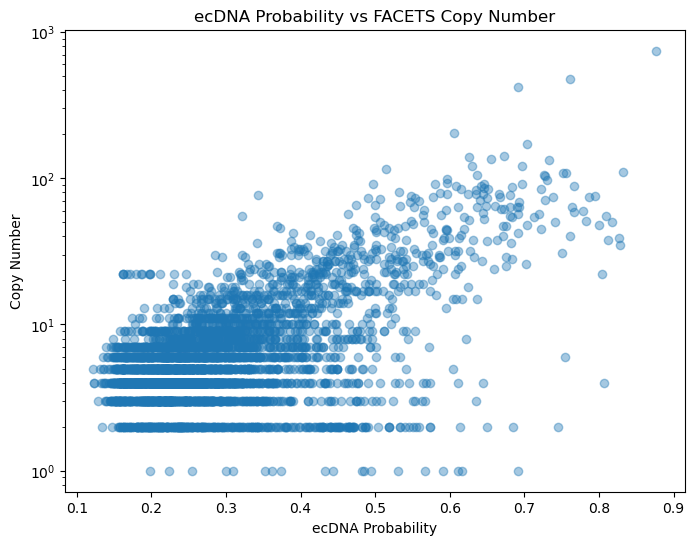

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(echo['ecDNA_prob'], echo['facets_cn'], alpha=0.4)
plt.ylabel("Copy Number")
plt.xlabel("ecDNA Probability")
plt.yscale('log')
plt.title("ecDNA Probability vs FACETS Copy Number")

### Landscape Plots

In [18]:
import math

# Add in info from cbioportal
ecDNA_patient['vitalStatus'] = 'NA'
ecDNA_patient['cancerType'] = 'NA'
ecDNA_patient['cancerTypeDetailed'] = 'NA'
ecDNA_patient['osMonths'] = np.nan
ecDNA_patient['oncogeneAmp'] = "No Amp"
ecDNA_patient['facetsAmp'] = "No Amp"

# Matches patientIds to indexes
ecDNA_patient_indexes = {}
for idx, row in ecDNA_patient.iterrows() :
    ecDNA_patient_indexes[row['patientId']] = idx

# Now the info is right from echo results!
for idx, row in echo.iterrows() :
    ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'vitalStatus'] = row['osStatus']
    ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'cancerType'] = row['cancerType']
    ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'cancerTypeDetailed'] = row['cancerTypeDetailed']
    ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'osMonths'] = row['osMonths']
    ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'facetsAmp'] = row['facets_amp_binary']

    if not math.isnan(row['ecDNA_prob']) :
        ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'oncogeneAmp'] = "Amp"

ecDNA_patient['ecDNAStatusStr'] = ecDNA_patient['ecDNAStatus'].replace({True: 'ecDNA', False: 'non-ecDNA'})
ecDNA_patient['combined_status'] = ecDNA_patient['ecDNAStatusStr'] + " & " + ecDNA_patient['oncogeneAmp']
ecDNA_patient['facets_combined_status'] = ecDNA_patient['ecDNAStatusStr'] + " & " + ecDNA_patient['facetsAmp']


In [19]:
ecDNA_patient_binary = ecDNA_patient[['vitalStatus', 'ecDNAStatus', analysis_type, 'oncogeneAmp', 'facetsAmp']].astype(str)
ecDNA_patient_binary_filtered = ecDNA_patient_binary.dropna(subset=[analysis_type])
ecDNA_patient_binary_filtered = ecDNA_patient_binary[ecDNA_patient_binary[analysis_type] != 'nan']

crosstab = pd.crosstab(ecDNA_patient_binary_filtered['oncogeneAmp'], ecDNA_patient_binary_filtered['ecDNAStatus'])
print("Using ECHO Amplification")
crosstab

Using ECHO Amplification


ecDNAStatus,False,True
oncogeneAmp,,
Amp,331,161
No Amp,1101,0


In [20]:
crosstab = pd.crosstab(ecDNA_patient_binary_filtered['facetsAmp'], ecDNA_patient_binary_filtered['ecDNAStatus'])
print("Using FACETS Amplification")
crosstab

Using FACETS Amplification


ecDNAStatus,False,True
facetsAmp,,
Amp,205,131
No Amp,1227,30


In [21]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# Change the labels from true/false to ecDNA status
ecDNA_patient_binary_filtered['ecDNAStatus'] = ecDNA_patient_binary_filtered['ecDNAStatus'].replace({'True': 'ecDNA', 'False': 'non-ecDNA'})
ecDNA_patient_binary_filtered['Status'] = ecDNA_patient_binary_filtered['ecDNAStatus'] + " & " + ecDNA_patient_binary_filtered['oncogeneAmp']
ecDNA_patient_binary_filtered['facetsStatus'] = ecDNA_patient_binary_filtered['ecDNAStatus'] + " & " + ecDNA_patient_binary_filtered['facetsAmp']

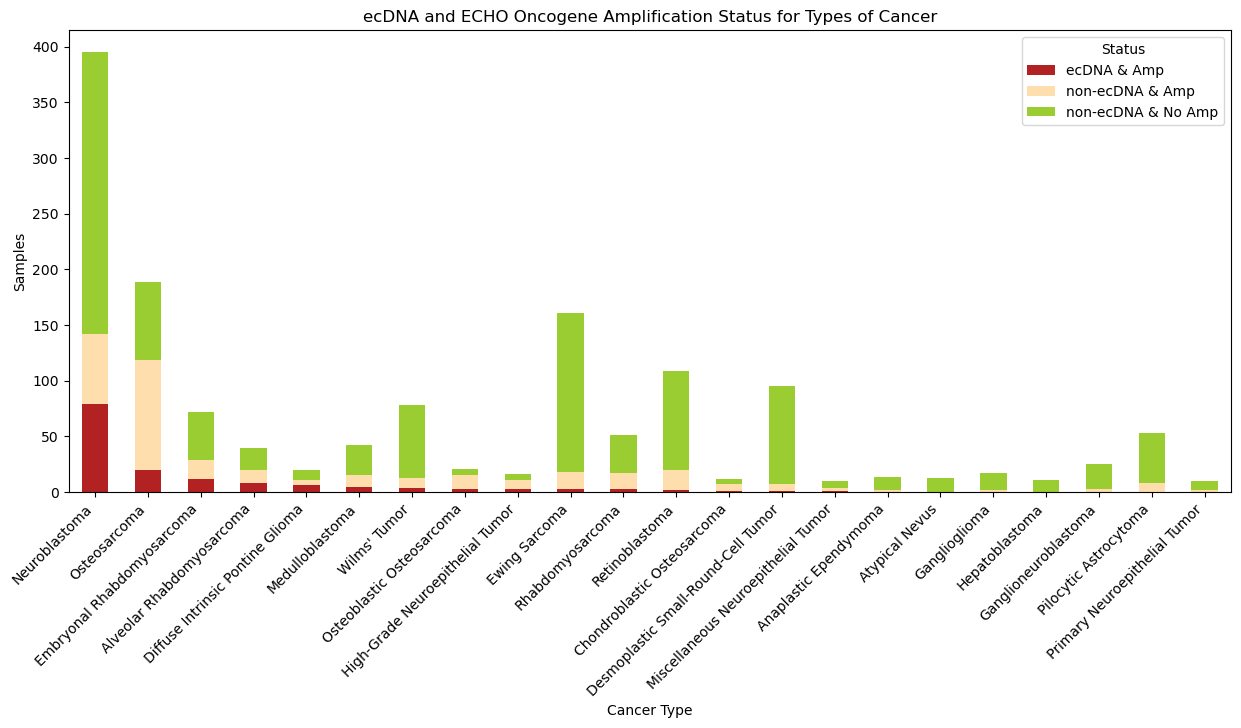

In [22]:
crosstab_cancerType = pd.crosstab(ecDNA_patient_binary_filtered[analysis_type], ecDNA_patient_binary_filtered['Status'])
crosstab_cancerType = crosstab_cancerType.loc[crosstab_cancerType.sum(axis = 1) >= 10]
crosstab_cancerType = crosstab_cancerType.sort_values(by = 'ecDNA & Amp', ascending = False)
crosstab_cancerType.plot(kind = 'bar', stacked = True, color = ['firebrick', 'navajowhite', 'yellowgreen'], figsize = (15, 6))
plt.ylabel("Samples")
plt.xlabel("Cancer Type")
plt.title("ecDNA and ECHO Oncogene Amplification Status for Types of Cancer")
plt.xticks(rotation=45, ha='right')
plt.show()

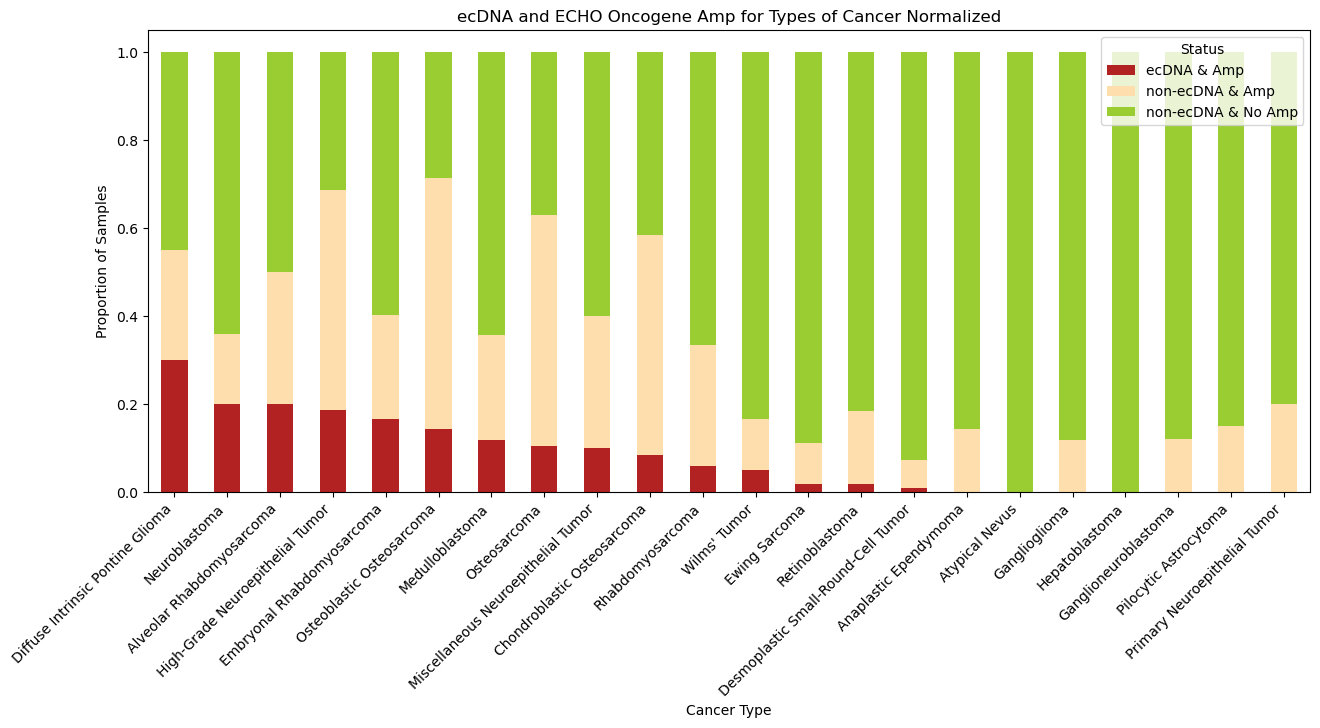

In [23]:
normalized_crosstab_cancerType = crosstab_cancerType.div(crosstab_cancerType.sum(axis = 1), axis = 0)
normalized_crosstab_cancerType = normalized_crosstab_cancerType.sort_values(by = 'ecDNA & Amp', ascending = False)
normalized_crosstab_cancerType.plot(kind = 'bar', stacked = True, color = ['firebrick', 'navajowhite', 'yellowgreen'], figsize=(15,6))
plt.ylabel("Proportion of Samples")
plt.xlabel("Cancer Type")
plt.title("ecDNA and ECHO Oncogene Amp for Types of Cancer Normalized")
plt.xticks(rotation=45, ha='right')
plt.show()

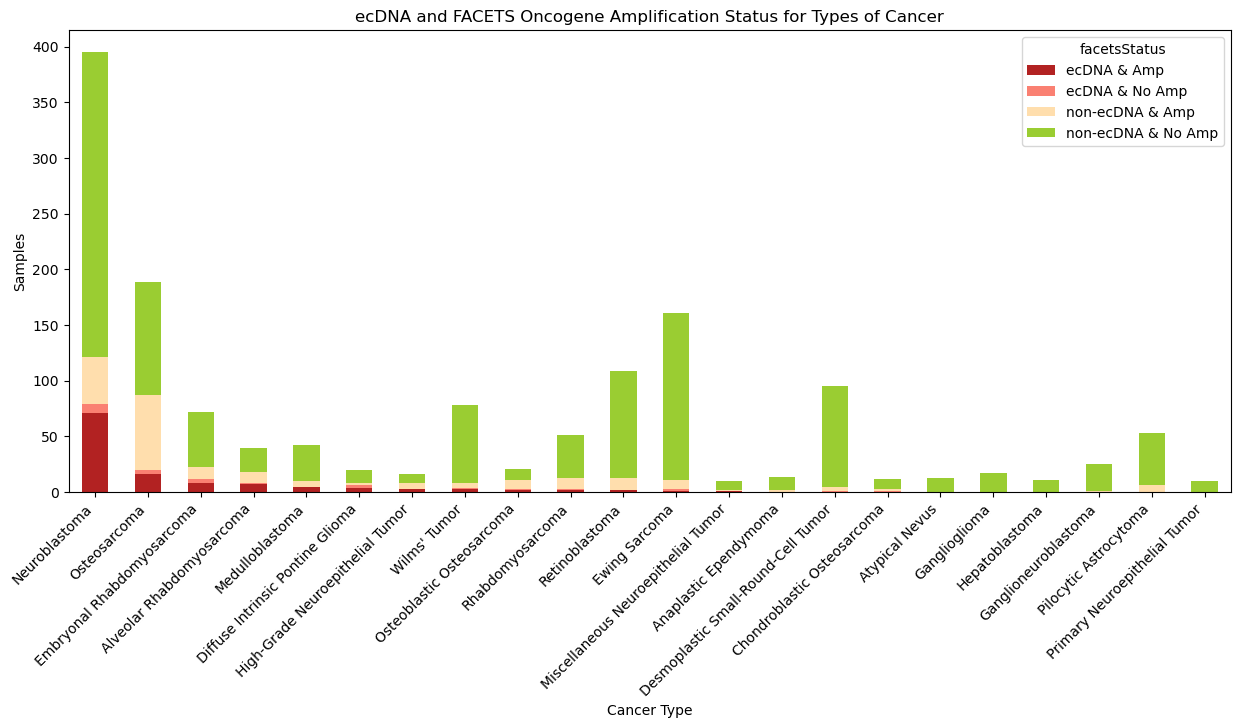

In [24]:
crosstab_cancerType = pd.crosstab(ecDNA_patient_binary_filtered[analysis_type], ecDNA_patient_binary_filtered['facetsStatus'])
crosstab_cancerType = crosstab_cancerType.loc[crosstab_cancerType.sum(axis = 1) >= 10]
crosstab_cancerType = crosstab_cancerType.sort_values(by = 'ecDNA & Amp', ascending = False)
crosstab_cancerType.plot(kind = 'bar', stacked = True, color = ['firebrick', 'salmon', 'navajowhite', 'yellowgreen'], figsize = (15, 6))
plt.ylabel("Samples")
plt.xlabel("Cancer Type")
plt.title("ecDNA and FACETS Oncogene Amplification Status for Types of Cancer")
plt.xticks(rotation=45, ha='right')
plt.show()

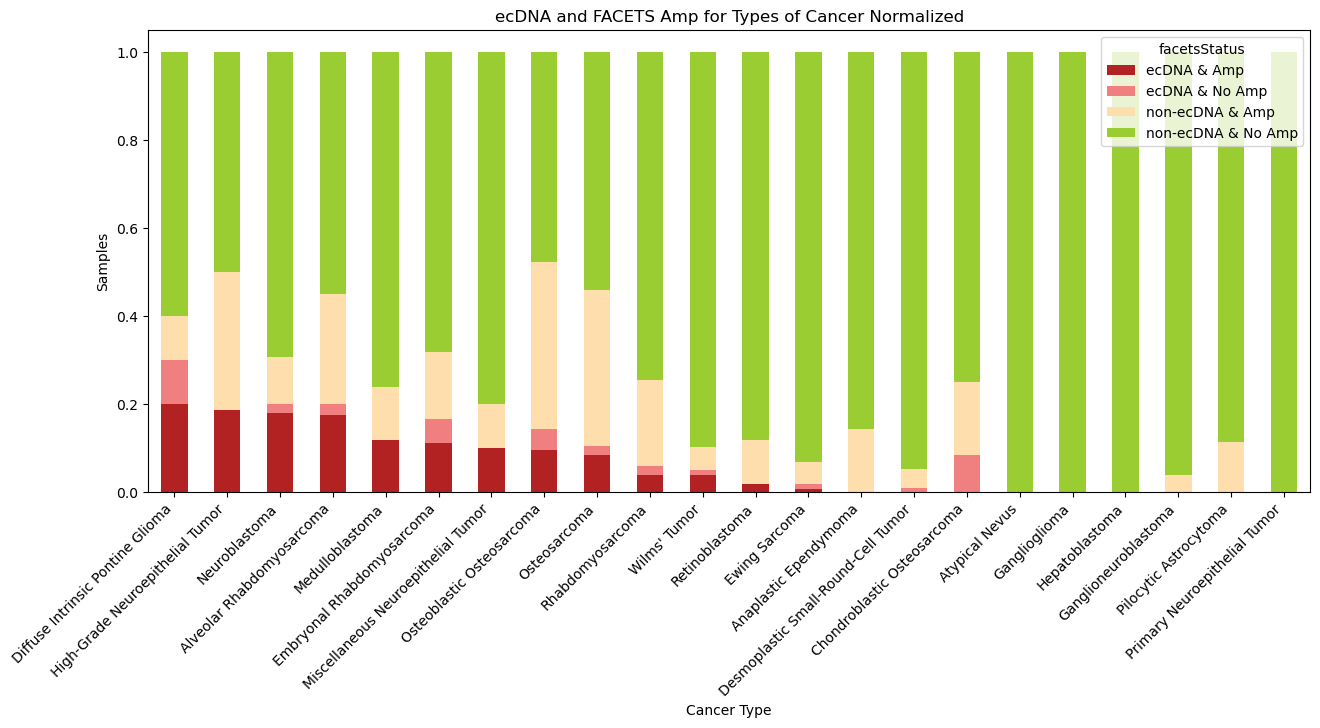

In [25]:
normalized_crosstab_cancerType = crosstab_cancerType.div(crosstab_cancerType.sum(axis = 1), axis = 0)
normalized_crosstab_cancerType = normalized_crosstab_cancerType.sort_values(by = 'ecDNA & Amp', ascending = False)
normalized_crosstab_cancerType.plot(kind = 'bar', stacked = True, color = ['firebrick', 'lightcoral', 'navajowhite', 'yellowgreen'], figsize=(15,6))
plt.ylabel("Samples")
plt.xlabel("Cancer Type")
plt.title("ecDNA and FACETS Amp for Types of Cancer Normalized")
plt.xticks(rotation=45, ha='right')
plt.show()

### Survival (OS Months)

Pure ecDNA vs no ecDNA

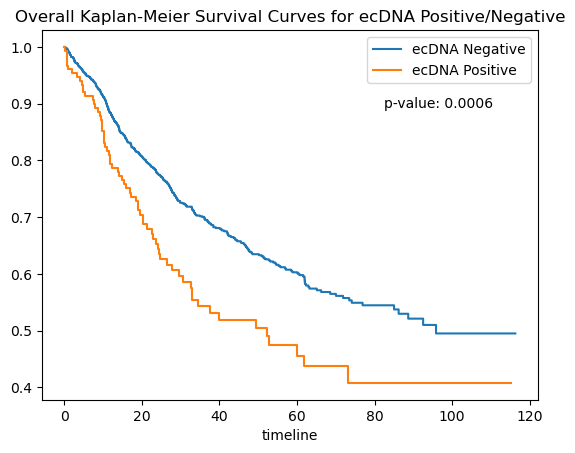

In [26]:
import warnings
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Ignore all warnings
warnings.filterwarnings('ignore')

ecDNA_patient_nona = ecDNA_patient.dropna(subset = ['ecDNAStatus', 'vitalStatus', 'osMonths'])
ecDNA_patient_nona['vitalStatus_tf'] = (ecDNA_patient_nona['vitalStatus'] == 'DECEASED').astype(int)

kmf = KaplanMeierFitter()
for status in ecDNA_patient_nona['ecDNAStatus'].unique():
    subset = ecDNA_patient_nona[ecDNA_patient_nona['ecDNAStatus'] == status]
    kmf.fit(subset['osMonths'], event_observed=(subset['vitalStatus'] == 'DECEASED'))
    subset['vitalStatus_tf'] = (subset['vitalStatus'] == 'DECEASED').astype(int)
    # labels
    if status == True :
        status = "ecDNA Positive"
    else :
        status = "ecDNA Negative"
    kmf.plot(show_censors=False, ci_show=False, label=f'{status}')

# get p-value
results = logrank_test(ecDNA_patient_nona[ecDNA_patient_nona['ecDNAStatus'] == True]['osMonths'], 
                           ecDNA_patient_nona[ecDNA_patient_nona['ecDNAStatus'] == False]['osMonths'],
                           event_observed_A=ecDNA_patient_nona[ecDNA_patient_nona['ecDNAStatus'] == True]['vitalStatus_tf'], 
                           event_observed_B=ecDNA_patient_nona[ecDNA_patient_nona['ecDNAStatus'] == False]['vitalStatus_tf'])
plt.text(0.8, 0.8, f'p-value: {results.p_value:.4f}', horizontalalignment='center', 
             verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

# # Add labels and legend
plt.title('Overall Kaplan-Meier Survival Curves for ecDNA Positive/Negative')

plt.legend()

Including Amplification Status (ecDNA making a call)

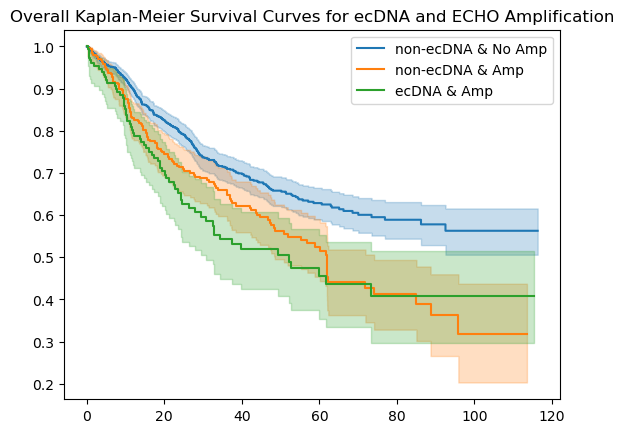

In [27]:
kmf = KaplanMeierFitter()
for status in ecDNA_patient_nona['combined_status'].unique():

    subset = ecDNA_patient_nona[ecDNA_patient_nona['combined_status'] == status]
    kmf.fit(subset['osMonths'], event_observed=(subset['vitalStatus'] == 'DECEASED'))

    kmf.plot(show_censors=False, ci_show=True, label=f'{status}')

# # Add labels and legend
plt.title('Overall Kaplan-Meier Survival Curves for ecDNA and ECHO Amplification')
plt.xlabel("")
plt.legend()

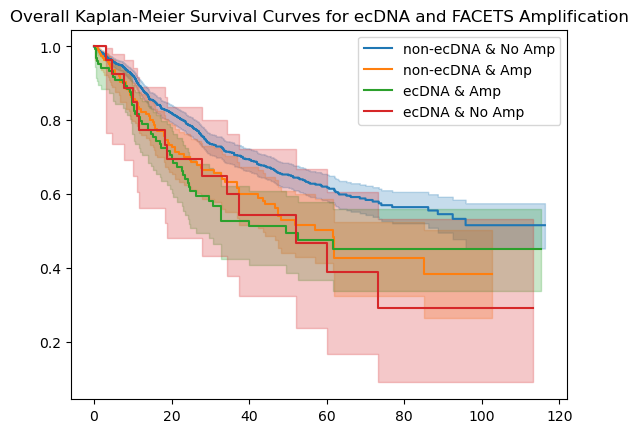

In [28]:
kmf = KaplanMeierFitter()
for status in ecDNA_patient_nona['facets_combined_status'].unique():
    subset = ecDNA_patient_nona[ecDNA_patient_nona['facets_combined_status'] == status]
    kmf.fit(subset['osMonths'], event_observed=(subset['vitalStatus'] == 'DECEASED'))

    kmf.plot(show_censors=False, ci_show=True, label=f'{status}')

# # Add labels and legend
plt.title('Overall Kaplan-Meier Survival Curves for ecDNA and FACETS Amplification')
plt.xlabel("")
plt.legend()

Make a p value matrix

In [29]:
from itertools import combinations
from lifelines.statistics import logrank_test

kmf = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

statuses = ecDNA_patient_nona['combined_status'].unique()
pairwise_tests = {}

for group1, group2 in combinations(statuses, 2) :
    group1_data = ecDNA_patient_nona[ecDNA_patient_nona['combined_status'] == group1]
    group2_data = ecDNA_patient_nona[ecDNA_patient_nona['combined_status'] == group2]

    # Fit KM curves
    kmf.fit(group1_data['osMonths'], event_observed=(group1_data['vitalStatus'] == 'DECEASED'))
    kmf2.fit(group2_data['osMonths'], event_observed=(group2_data['vitalStatus'] == 'DECEASED'))
    
    # Perform log-rank test
    result = logrank_test(group1_data['osMonths'], group2_data['osMonths'], event_observed_A=(group1_data['vitalStatus'] == 'DECEASED'), event_observed_B=(group2_data['vitalStatus'] == 'DECEASED'))
    
    # Store p-value in dictionary
    pairwise_tests[(group1, group2)] = result.p_value

p_values_matrix = pd.DataFrame(index=statuses, columns=statuses)
for (group1, group2), p_value in pairwise_tests.items():
    if group1 != group2:
        p_values_matrix.loc[group1, group2] = p_value
p_values_matrix = p_values_matrix.fillna("")

print("P-values for KM Curves")

styled_matrix = p_values_matrix.iloc[:-1, 1:].style.set_table_styles([{
    'selector': 'th',
    'props': [('border', '1px solid black')]
}, {
    'selector': 'td',
    'props': [('border', '1px solid black')]
}])
styled_matrix

P-values for KM Curves


,non-ecDNA & Amp,ecDNA & Amp
non-ecDNA & No Amp,0.000168,0.000031
non-ecDNA & Amp,,0.332375


In [30]:
from itertools import combinations
from lifelines.statistics import logrank_test

kmf = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

statuses = ecDNA_patient_nona['facets_combined_status'].unique()
pairwise_tests = {}

for group1, group2 in combinations(statuses, 2) :
    group1_data = ecDNA_patient_nona[ecDNA_patient_nona['facets_combined_status'] == group1]
    group2_data = ecDNA_patient_nona[ecDNA_patient_nona['facets_combined_status'] == group2]

    # Fit KM curves
    kmf.fit(group1_data['osMonths'], event_observed=(group1_data['vitalStatus'] == 'DECEASED'))
    kmf2.fit(group2_data['osMonths'], event_observed=(group2_data['vitalStatus'] == 'DECEASED'))
    
    # Perform log-rank test
    result = logrank_test(group1_data['osMonths'], group2_data['osMonths'], event_observed_A=(group1_data['vitalStatus'] == 'DECEASED'), event_observed_B=(group2_data['vitalStatus'] == 'DECEASED'))
    
    # Store p-value in dictionary
    pairwise_tests[(group1, group2)] = result.p_value

p_values_matrix = pd.DataFrame(index=statuses, columns=statuses)
for (group1, group2), p_value in pairwise_tests.items():
    if group1 != group2:
        p_values_matrix.loc[group1, group2] = p_value
p_values_matrix = p_values_matrix.fillna("")

print("P-values for KM Curves")

styled_matrix = p_values_matrix.iloc[:-1, 1:].style.set_table_styles([{
    'selector': 'th',
    'props': [('border', '1px solid black')]
}, {
    'selector': 'td',
    'props': [('border', '1px solid black')]
}])
styled_matrix

P-values for KM Curves


,non-ecDNA & Amp,ecDNA & Amp,ecDNA & No Amp
non-ecDNA & No Amp,0.001367,0.000487,0.049413
non-ecDNA & Amp,,0.552784,0.666878
ecDNA & Amp,,,0.887937


Specific for one cancer type

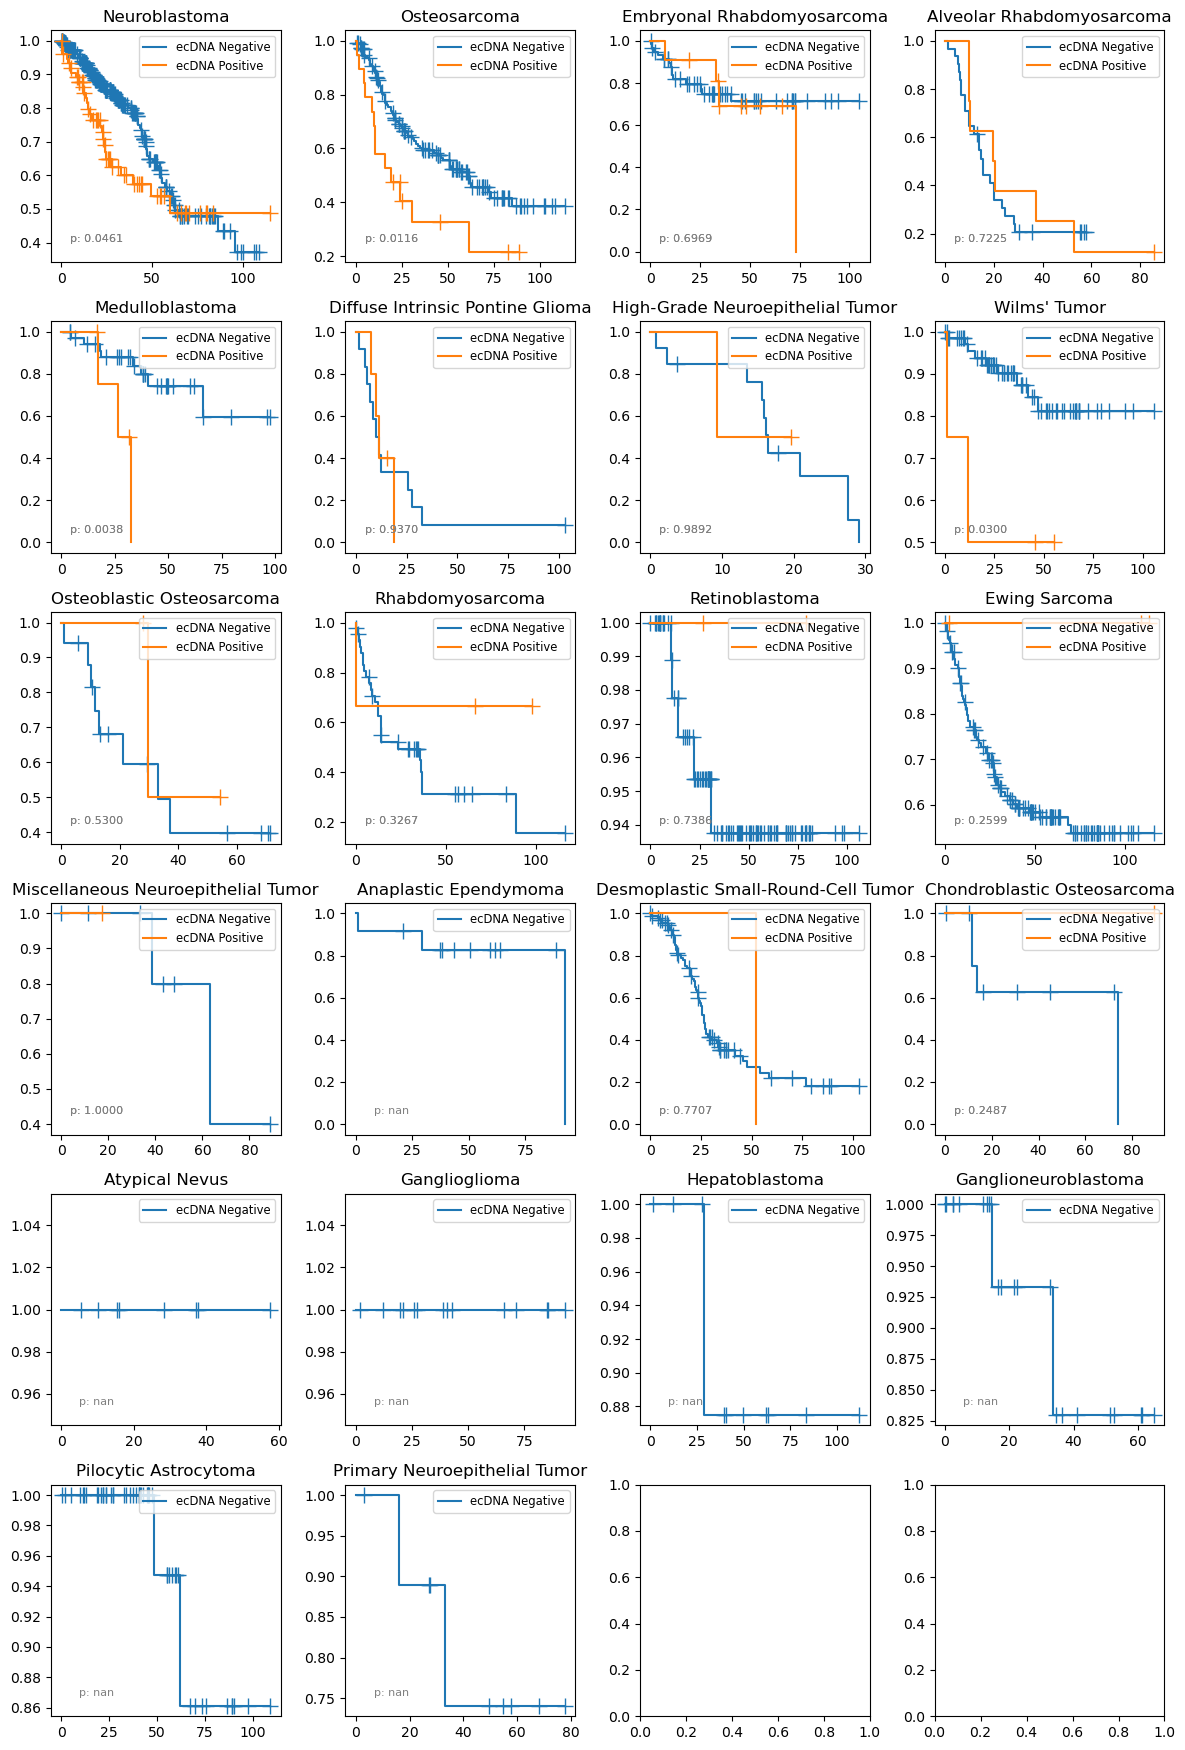

In [31]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

from lifelines import KaplanMeierFitter

ecDNA_patient_nona = ecDNA_patient.dropna(subset = ['ecDNAStatus', 'vitalStatus', 'osMonths', analysis_type])
cancer_types = crosstab_cancerType.index.tolist()

# Allow for multiple plots
fig, axs = plt.subplots((len(cancer_types)+3)//4, 4, figsize = (12, 0.8 * len(cancer_types)))
axs = axs.flatten()
for i in range(len(cancer_types)) :
    # Get specific data set for the cancer type
    ecDNA_patient_specific = ecDNA_patient_nona[ecDNA_patient_nona[analysis_type] == cancer_types[i]]
    ecDNA_patient_specific['vitalStatus_tf'] = (ecDNA_patient_specific['vitalStatus'] == 'DECEASED').astype(int)

    for status in sorted(ecDNA_patient_specific['ecDNAStatus'].unique()):

        kmf = KaplanMeierFitter()
        subset = ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == status]
        kmf.fit(subset['osMonths'], event_observed=(subset['vitalStatus'] == 'DECEASED'))
        # labels
        if status == True :
            status = "ecDNA Positive"
        else :
            status = "ecDNA Negative"
        kmf.plot(show_censors=True, ci_show=False, label=f'{status}', ax = axs[i])
        axs[i].legend(loc='upper right', fontsize='small')

        axs[i].set_title(cancer_types[i])
        axs[i].set_xlabel("")
    
        # Get p value
        try :
            results = logrank_test(ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == True]['osMonths'], 
                                    ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == False]['osMonths'],
                                    event_observed_A=ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == True]['vitalStatus_tf'], 
                                    event_observed_B=ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == False]['vitalStatus_tf'])
            if not results.p_value == np.nan :
                axs[i].text(0.2,0.1, f'p: {results.p_value:.4f}', horizontalalignment='center',
                    verticalalignment='center',
                    transform=axs[i].transAxes,
                    fontsize=8, 
                    color='grey')
        except :
            _ = 5
plt.tight_layout()
plt.show()

With amplification status

Using ECHO Amplifications


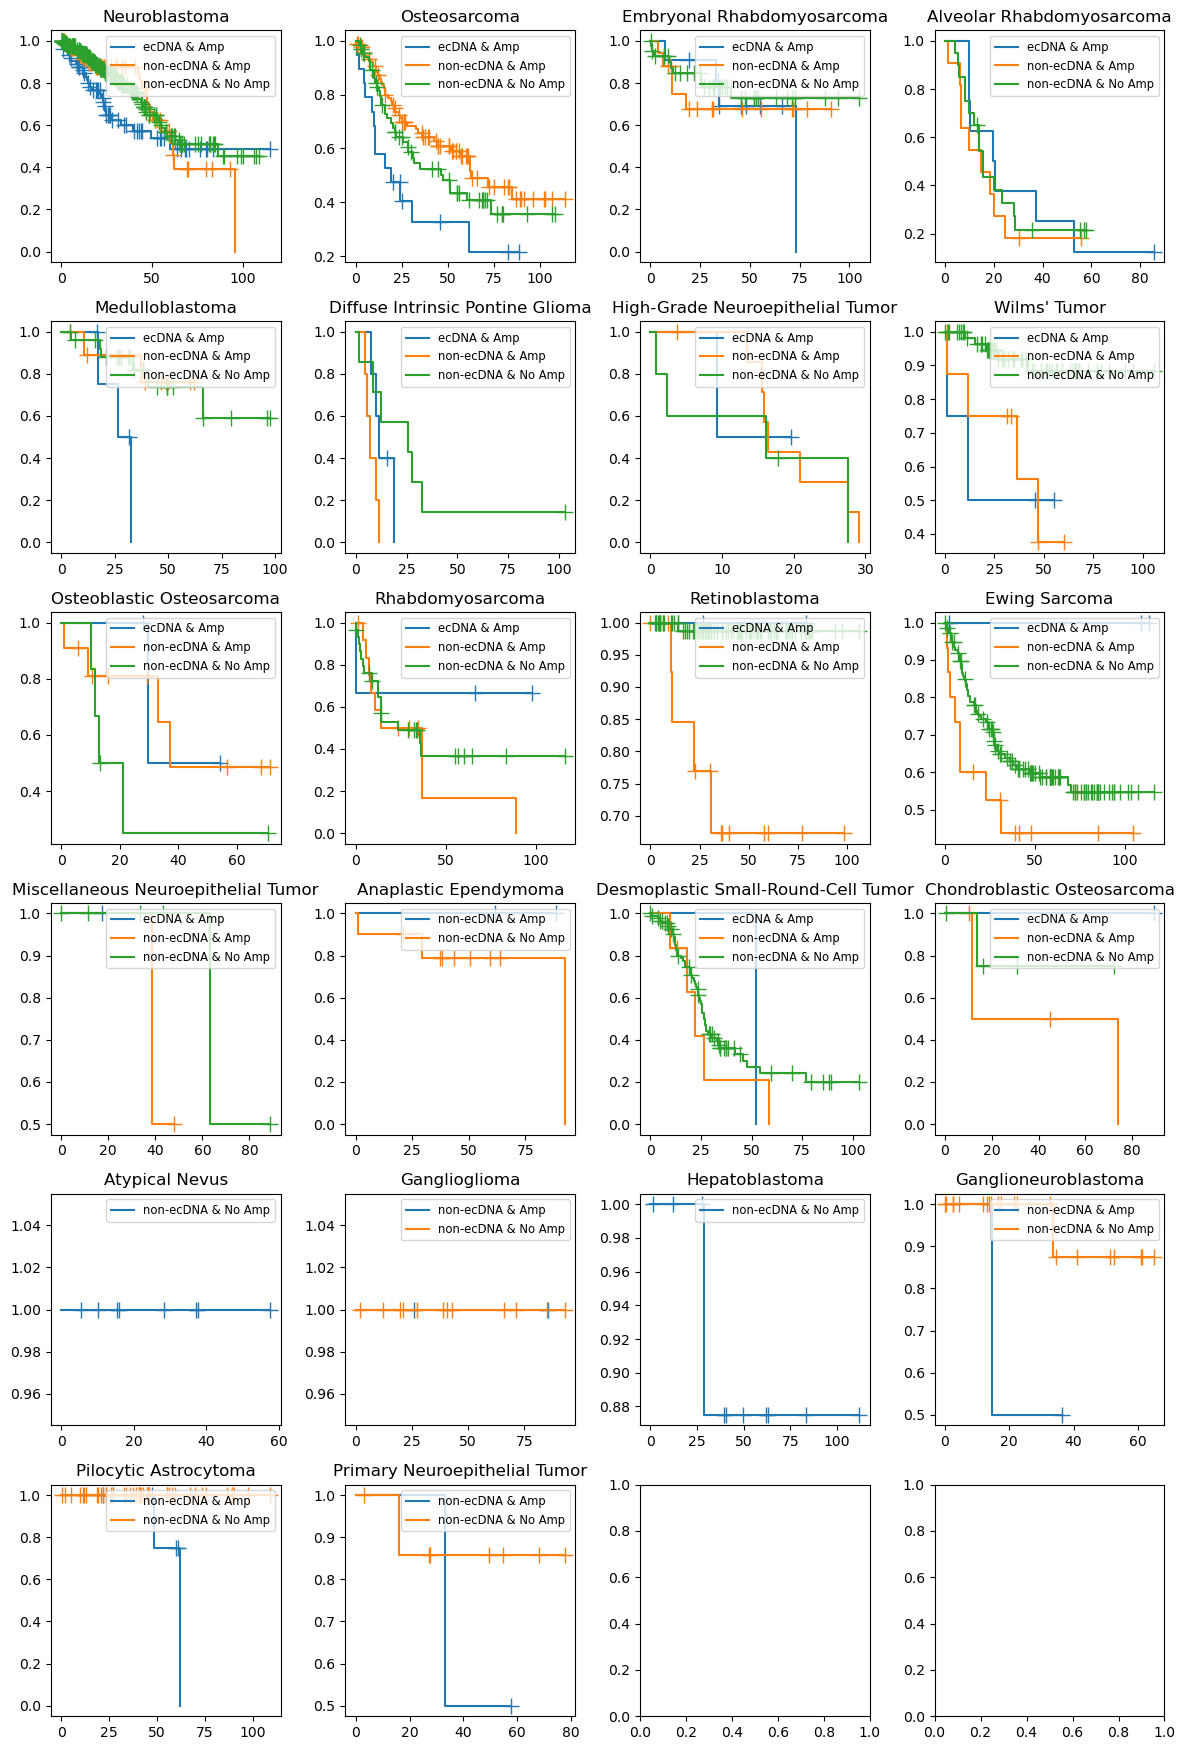

In [32]:
import warnings

print("Using ECHO Amplifications")
# Ignore all warnings
warnings.filterwarnings('ignore')

cancer_types = crosstab_cancerType.index.tolist()

ecDNA_patient_nona = ecDNA_patient.dropna(subset = ['ecDNAStatus', 'vitalStatus', 'osMonths', analysis_type])

# Allow for multiple plots
fig, axs = plt.subplots((len(cancer_types)+3)//4, 4, figsize = (12, 0.8 * len(cancer_types)))
axs = axs.flatten()
for i in range(len(cancer_types)) :
    # Get specific data set for the cancer type
    ecDNA_patient_specific = ecDNA_patient_nona[ecDNA_patient_nona[analysis_type] == cancer_types[i]]
    ecDNA_patient_specific['vitalStatus_tf'] = (ecDNA_patient_specific['vitalStatus'] == 'DECEASED').astype(int)

    for status in sorted(ecDNA_patient_specific['combined_status'].unique()):

        kmf = KaplanMeierFitter()
        subset = ecDNA_patient_specific[ecDNA_patient_specific['combined_status'] == status]
        kmf.fit(subset['osMonths'], event_observed=(subset['vitalStatus'] == 'DECEASED'))

        kmf.plot(show_censors=True, ci_show=False, label=f'{status}', ax = axs[i])
        axs[i].legend(loc='upper right', fontsize='small')

        axs[i].set_title(cancer_types[i])
        axs[i].set_xlabel("")
plt.tight_layout()
plt.show()

Using FACETS Amplifications


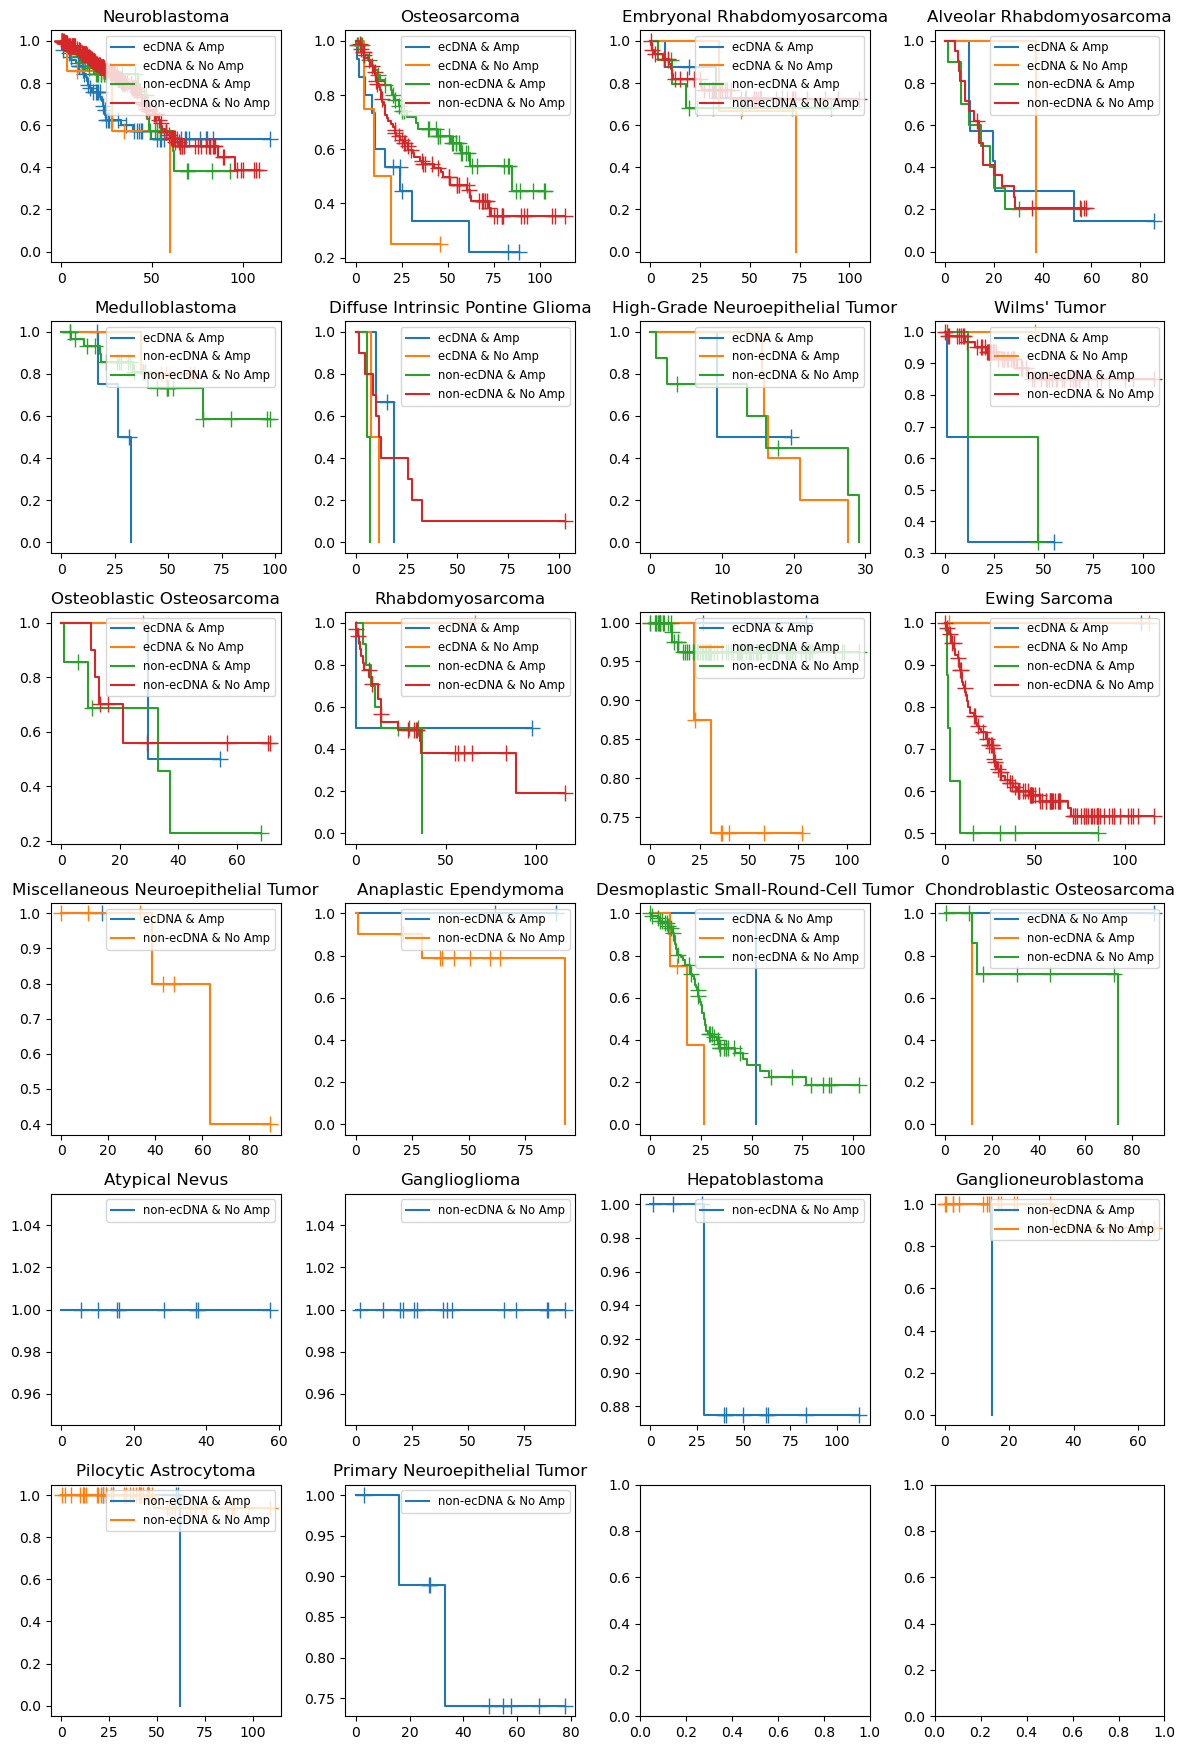

In [33]:
import warnings

print("Using FACETS Amplifications")
# Ignore all warnings
warnings.filterwarnings('ignore')

cancer_types = crosstab_cancerType.index.tolist()

ecDNA_patient_nona = ecDNA_patient.dropna(subset = ['ecDNAStatus', 'vitalStatus', 'osMonths', analysis_type])

# Allow for multiple plots
fig, axs = plt.subplots((len(cancer_types)+3)//4, 4, figsize = (12, 0.8 * len(cancer_types)))
axs = axs.flatten()
for i in range(len(cancer_types)) :
    # Get specific data set for the cancer type
    ecDNA_patient_specific = ecDNA_patient_nona[ecDNA_patient_nona[analysis_type] == cancer_types[i]]
    ecDNA_patient_specific['vitalStatus_tf'] = (ecDNA_patient_specific['vitalStatus'] == 'DECEASED').astype(int)

    for status in sorted(ecDNA_patient_specific['facets_combined_status'].unique()):

        kmf = KaplanMeierFitter()
        subset = ecDNA_patient_specific[ecDNA_patient_specific['facets_combined_status'] == status]
        kmf.fit(subset['osMonths'], event_observed=(subset['vitalStatus'] == 'DECEASED'))

        kmf.plot(show_censors=True, ci_show=False, label=f'{status}', ax = axs[i])
        axs[i].legend(loc='upper right', fontsize='small')

        axs[i].set_title(cancer_types[i])
        axs[i].set_xlabel("")
plt.tight_layout()
plt.show()

### Hazard Ratio Analysis

Cox model

In [34]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

ecDNA_patient_cox = ecDNA_patient.dropna(subset = ['osMonths', 'ecDNAStatus', analysis_type])
# Change to 1 or 0
ecDNA_patient_cox['eventOccurred'] = (ecDNA_patient_cox['vitalStatus'] == 'DECEASED').astype(int)

from lifelines import CoxPHFitter

cox = CoxPHFitter()
covariates = ['osMonths', 'eventOccurred', 'ecDNAStatus']
cox.fit(ecDNA_patient_cox[covariates], duration_col = 'osMonths', event_col = 'eventOccurred')
print(cox.summary)

                 coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                    
ecDNAStatus  0.448697   1.566269  0.131595        0.190776        0.706618   

             exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                 
ecDNAStatus             1.210188             2.027123     0.0  3.409685   

                   p   -log2(p)  
covariate                        
ecDNAStatus  0.00065  10.586429  


With amplification status

In [35]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

ecDNA_patient_cox = ecDNA_patient.dropna(subset = ['osMonths', 'ecDNAStatus', analysis_type, 'oncogeneAmp'])
# Change to 1 or 0
ecDNA_patient_cox['eventOccurred'] = (ecDNA_patient_cox['vitalStatus'] == 'DECEASED').astype(int)
ecDNA_patient_cox['ampOccurred'] = (ecDNA_patient_cox['oncogeneAmp'] == 'Amp').astype(int)

from lifelines import CoxPHFitter

cox = CoxPHFitter()
covariates = ['osMonths', 'eventOccurred', 'ecDNAStatus', 'ampOccurred']
cox.fit(ecDNA_patient_cox[covariates], duration_col = 'osMonths', event_col = 'eventOccurred')
print("Using ECHO Amplifications")
print(cox.summary)

Using ECHO Amplifications
                 coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                    
ecDNAStatus  0.157125   1.170142  0.150861       -0.138558        0.452808   
ampOccurred  0.396297   1.486310  0.105968        0.188603        0.603990   

             exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                 
ecDNAStatus             0.870613             1.572722     0.0  1.041518   
ampOccurred             1.207562             1.829403     0.0  3.739779   

                    p   -log2(p)  
covariate                         
ecDNAStatus  0.297635   1.748384  
ampOccurred  0.000184  12.406581  


In [36]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

ecDNA_patient_cox = ecDNA_patient.dropna(subset = ['osMonths', 'ecDNAStatus', analysis_type, 'oncogeneAmp'])
# Change to 1 or 0
ecDNA_patient_cox['eventOccurred'] = (ecDNA_patient_cox['vitalStatus'] == 'DECEASED').astype(int)
ecDNA_patient_cox['ampOccurred'] = (ecDNA_patient_cox['facetsAmp'] == 'Amp').astype(int)

from lifelines import CoxPHFitter

cox = CoxPHFitter()
covariates = ['osMonths', 'eventOccurred', 'ecDNAStatus', 'ampOccurred']
cox.fit(ecDNA_patient_cox[covariates], duration_col = 'osMonths', event_col = 'eventOccurred')
print("Using FACETS Amplifications")
print(cox.summary)

Using FACETS Amplifications
                 coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                    
ecDNAStatus  0.223147   1.250004  0.153558       -0.077821        0.524115   
ampOccurred  0.339581   1.404359  0.118979        0.106386        0.572776   

             exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                 
ecDNAStatus             0.925130             1.688963     0.0  1.453176   
ampOccurred             1.112251             1.773183     0.0  2.854116   

                    p  -log2(p)  
covariate                        
ecDNAStatus  0.146175  2.774233  
ampOccurred  0.004316  7.856197  


In [37]:
import warnings
warnings.filterwarnings("ignore")

ecDNA_patient_cox = ecDNA_patient.dropna(subset = ['osMonths', 'ecDNAStatus', analysis_type])
from lifelines import CoxPHFitter

cox_df = pd.DataFrame(columns = ['ctype', 'p_value', 'hazardRatio', 'upper', 'lower'])

# Create a dataframe for cox model output for each cancer type
for ctype in crosstab_cancerType.index.tolist() :
    try :
        ecDNA_patient_cox_specific = ecDNA_patient_cox[ecDNA_patient_cox[analysis_type] == ctype]
        ecDNA_patient_cox_specific['eventOccurred'] = (ecDNA_patient_cox_specific['vitalStatus'] == 'DECEASED').astype(int)

        cox = CoxPHFitter()
        covariates = ['osMonths', 'eventOccurred', 'ecDNAStatus']
        cox.fit(ecDNA_patient_cox_specific[covariates], duration_col = 'osMonths', event_col = 'eventOccurred')
        new_row = {
            'ctype' : ctype,
            'p_value' : cox.summary['p'][0],
            'hazardRatio' : cox.summary['exp(coef)'][0],
            'upper' : cox.summary['exp(coef) upper 95%'][0],
            'lower' : cox.summary['exp(coef) lower 95%'][0]
        }
        new_df = pd.DataFrame([new_row])
        cox_df = pd.concat([cox_df, new_df], ignore_index = True)

    except :
        print(f"{ctype}: Convergence Not Found")

Anaplastic Ependymoma: Convergence Not Found
Atypical Nevus: Convergence Not Found
Ganglioglioma: Convergence Not Found
Hepatoblastoma: Convergence Not Found
Ganglioneuroblastoma: Convergence Not Found
Pilocytic Astrocytoma: Convergence Not Found
Primary Neuroepithelial Tumor: Convergence Not Found


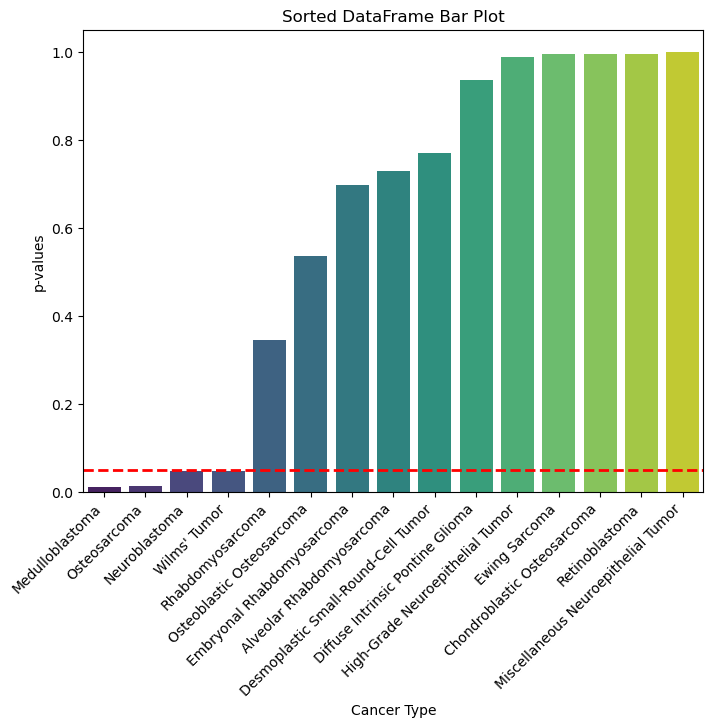

In [38]:
import seaborn as sns

cox_df = cox_df.sort_values(by='p_value')
plt.figure(figsize=(8, 6))
bars = sns.barplot(x='ctype', y='p_value', data=cox_df, palette='viridis')
plt.xlabel('Cancer Type')
plt.ylabel('p-values')
plt.title('Sorted DataFrame Bar Plot')
bars.set_xticklabels(bars.get_xticklabels(), rotation=45, ha='right')
plt.axhline(y=0.05, color='r', linestyle='--', linewidth=2)

plt.show()

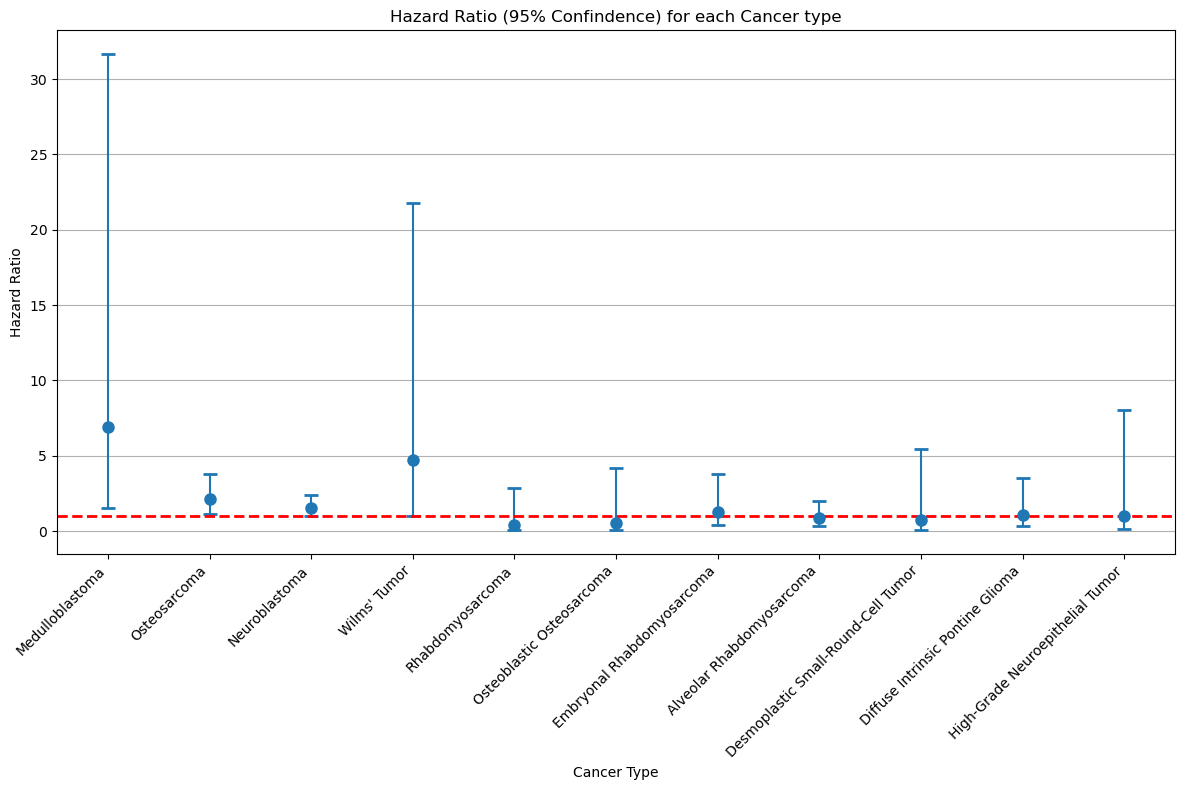

In [39]:
non_zero = cox_df[cox_df['lower'] != 0]

# Number of rows in the DataFrame
num_rows = non_zero.shape[0]

# Plotting points with error bars for each row
plt.figure(figsize=(12, 8))

# Plot points
positions = np.arange(num_rows)
plt.errorbar(positions, non_zero['hazardRatio'], yerr=[non_zero['hazardRatio'] - non_zero['lower'], non_zero['upper'] - non_zero['hazardRatio']],
             fmt='o', markersize=8, capsize=5, capthick=2)

# Set x-axis ticks and labels
plt.xlabel('Cancer Type')
plt.xticks(positions, non_zero['ctype'],rotation=45, ha='right')


# Add labels and title
plt.ylabel('Hazard Ratio')
plt.title('Hazard Ratio (95% Confindence) for each Cancer type')
plt.axhline(y=1, color='r', linestyle='--', linewidth=2)

plt.grid(True, axis='y')  # Add grid lines for better visualization
plt.tight_layout()
plt.show()

### Gene Level

In [40]:
# Count the number of times each gene is called
gene_called_nonecDNA_count = {}
gene_ecDNA_count = {}

for idx, row in echo.iterrows() :
    if row['ecDNA_status'] == 'ecDNA' :
        if row['gene'] in gene_ecDNA_count :
            gene_ecDNA_count[row['gene']] += 1
        else :
            gene_ecDNA_count[row['gene']] = 1
        if not row['gene'] in gene_called_nonecDNA_count :
            gene_called_nonecDNA_count[row['gene']] = 0
    elif row['ecDNA_status'] == 'non-ecDNA' :
        if row['gene'] in gene_called_nonecDNA_count :
            gene_called_nonecDNA_count[row['gene']] += 1
        else :
            gene_called_nonecDNA_count[row['gene']] = 1




Get IMPACT Lists for correction

In [41]:
# These should be in the notebook directory
im3 = pd.read_excel("./IMPACT341-Gene-List_20140101.xlsx")
im3_genes = set(im3['Gene_Symbol'].unique())

im5 = pd.read_excel("./IMPACT410-Gene-List_20150201.xlsx")
im5_genes = set(im5['Gene_Symbol'].unique())

im6 = pd.read_excel("./impact-genes-468.xlsx")
im6_genes = set(im6['Approved Symbol'].unique())

im7 = pd.read_excel("./IMPACT505_Gene_list_detailed.xlsx", header = None)
im7_genes = set()
for column in im7.columns:
    im7_genes.update(im7[column].unique())
im7_genes.remove(np.nan)

In [42]:
# Count the number of samples in each 
number_im3 = 0
number_im5 = 0
number_im6 = 0
number_im7 = 0

for sample in echo['sampleId'].unique() :
    try :
        if sample[-3:] == "IM3" :
            number_im3 += 1
        elif sample[-3:] == "IM5" :
            number_im5 += 1
        elif sample[-3:] == "IM6" :
            number_im6 += 1
        elif sample[-3:] == "IM7" :
            number_im7+= 1
    except :
        print(f"Warning: {sample}")

print(f"IM3: {number_im3}")
print(f"IM5: {number_im5}")
print(f"IM6: {number_im6}")
print(f"IM7: {number_im7}")

IM3: 38
IM5: 191
IM6: 1007
IM7: 860


Plot top genes

In [43]:
gene_ecDNA_percentages = {}

for gene in gene_ecDNA_count :
    new_gene = gene
    # These have alternate names that are used
    if new_gene == "NSD3" :
        new_gene = "WHSC1L1"
    if new_gene == "ELOC" :
        new_gene = "TCEB1"
    if new_gene == "H2BC5" :
        new_gene = "HIST1H2BD"
    if new_gene == "ABRAXAS1" :
        new_gene = "FAM175A"
    if new_gene == "MYCL" :
        new_gene = "MYCL1"
    
    # Tally number for each gene
    total_num = 0
    if new_gene in im3_genes :
        total_num += number_im3
    if new_gene in im5_genes :
        total_num += number_im5
    if new_gene in im6_genes :
        total_num += number_im6
    if new_gene in im7_genes :
        total_num += number_im7

    # Default to max number
    if total_num == 0 :
        print(f"{gene} Not Found. Using {number_im3 + number_im5 + number_im6 + number_im7}")
        total_num = number_im3 + number_im5 + number_im6 + number_im7
    gene_ecDNA_percentages[gene] = gene_ecDNA_count[gene]/total_num


EWSR1 Not Found. Using 2096
GTF2I Not Found. Using 2096
PAX8 Not Found. Using 2096
STAT6 Not Found. Using 2096


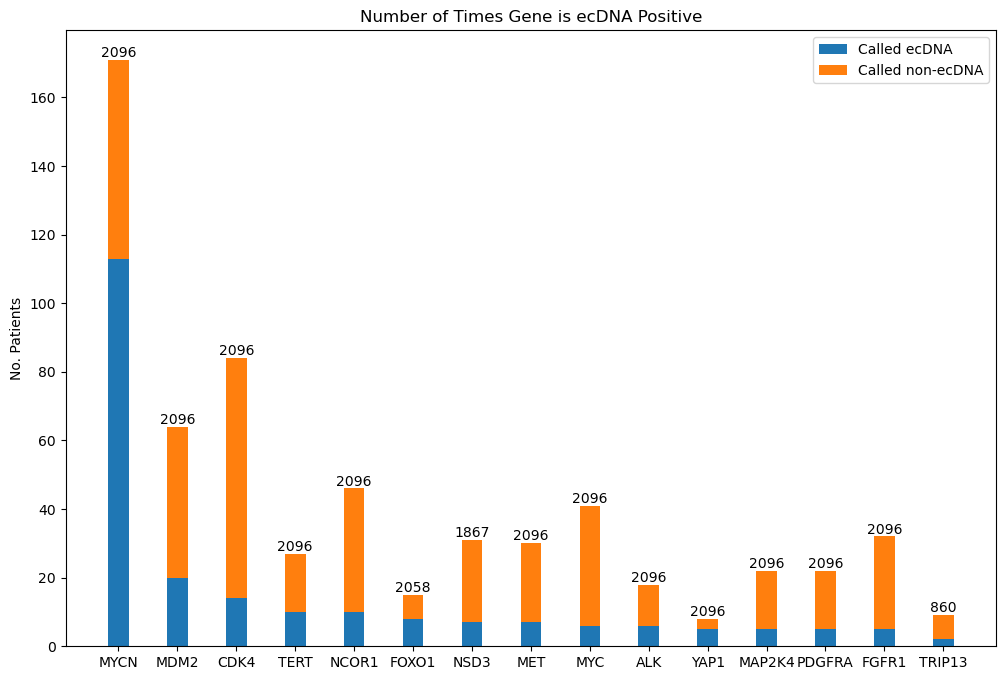

In [44]:
# Pick out top 15 from sorted proportion of ecDNA positive
gene_ecDNA_top15 = dict(sorted(gene_ecDNA_percentages.items(), key=lambda x: x[1], reverse=True)[:15])

keys = gene_ecDNA_top15.keys()
ecDNA_neg = [gene_called_nonecDNA_count[key] for key in keys]
ecDNA_pos = [gene_ecDNA_count[key] for key in keys]

ind = np.arange(len(keys))
width = 0.35

plt.figure(figsize = (12, 8))
p1 = plt.bar(ind, ecDNA_pos, width)
p2 = plt.bar(ind, ecDNA_neg, width, bottom=ecDNA_pos)

for i, value in enumerate(gene_ecDNA_top15) :
    # Change gene names
    if value == "NSD3" :
        value = "WHSC1L1"
    if value == "ELOC" :
        value = "TCEB1"
    if value == "H2BC5" :
        value = "HIST1H2BD"
    if value == "ABRAXAS1" :
        value = "FAM175A"
    if value == "MYCL" :
        value = "MYCL1"

    # Put labels for each which are the number of samples the gene was queried in
    total_num = 0
    if value in im3_genes :
        total_num += number_im3
    if value in im5_genes :
        total_num += number_im5
    if value in im6_genes :
        total_num += number_im6
    if value in im7_genes :
        total_num += number_im7
    plt.text(i, ecDNA_neg[i] + ecDNA_pos[i], str(total_num), ha = 'center', va = 'bottom')

plt.ylabel('No. Patients')
plt.title('Number of Times Gene is ecDNA Positive')
plt.xticks(ind, keys)
plt.legend((p1[0], p2[0]), ('Called ecDNA', 'Called non-ecDNA'))

plt.show()

Which cancers did these genes come from?

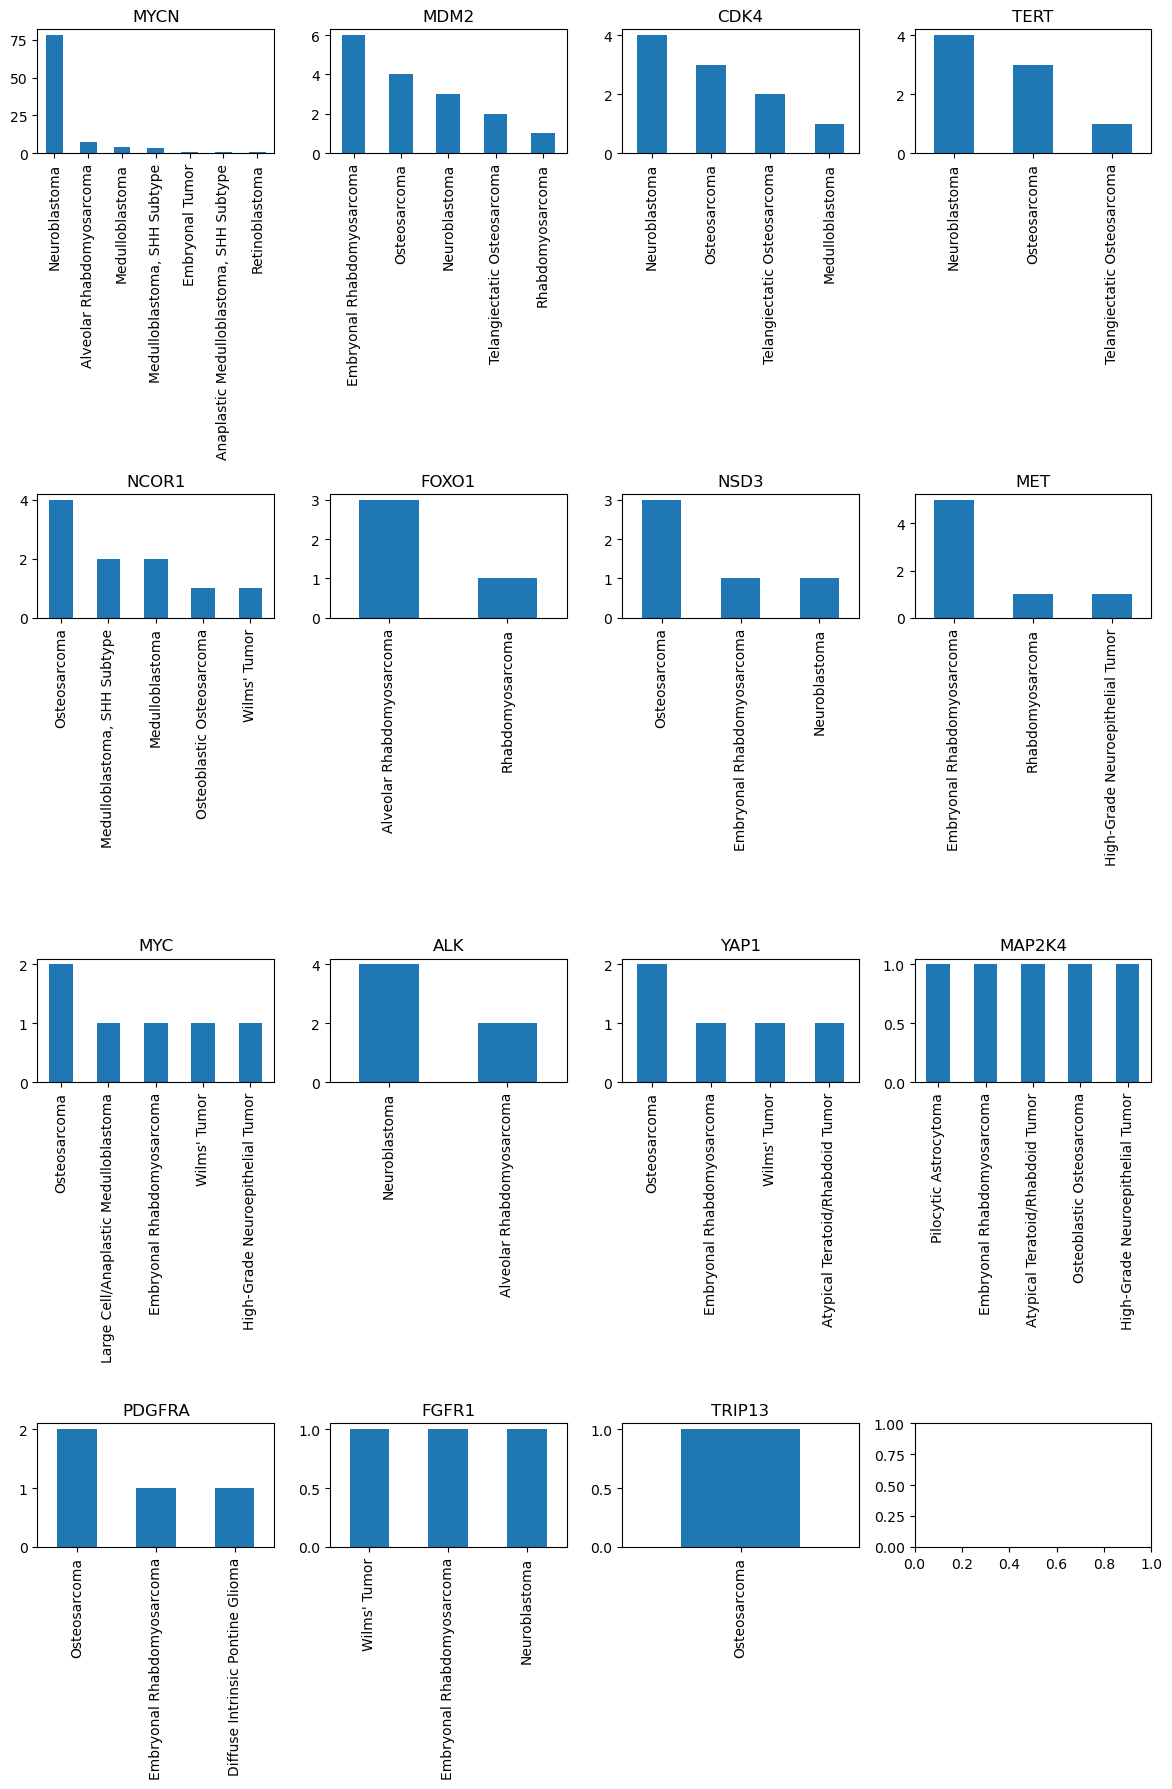

In [45]:
fig, axs = plt.subplots((len(gene_ecDNA_top15)+3)//4, 4, figsize = (12, 1.2 * len(gene_ecDNA_top15)))
axs = axs.flatten()

for i, gene in enumerate(gene_ecDNA_top15) :
        subset = echo[echo['gene'] == gene]
        subset = subset[subset['ecDNA_status'] == 'ecDNA']
        
        counts = subset[analysis_type].value_counts()
        counts.plot(kind = 'bar', ax = axs[i])
        axs[i].set_title(gene)
        axs[i].set_xlabel('')
fig.tight_layout()



Normalized by counts of each cancer (patient wise)

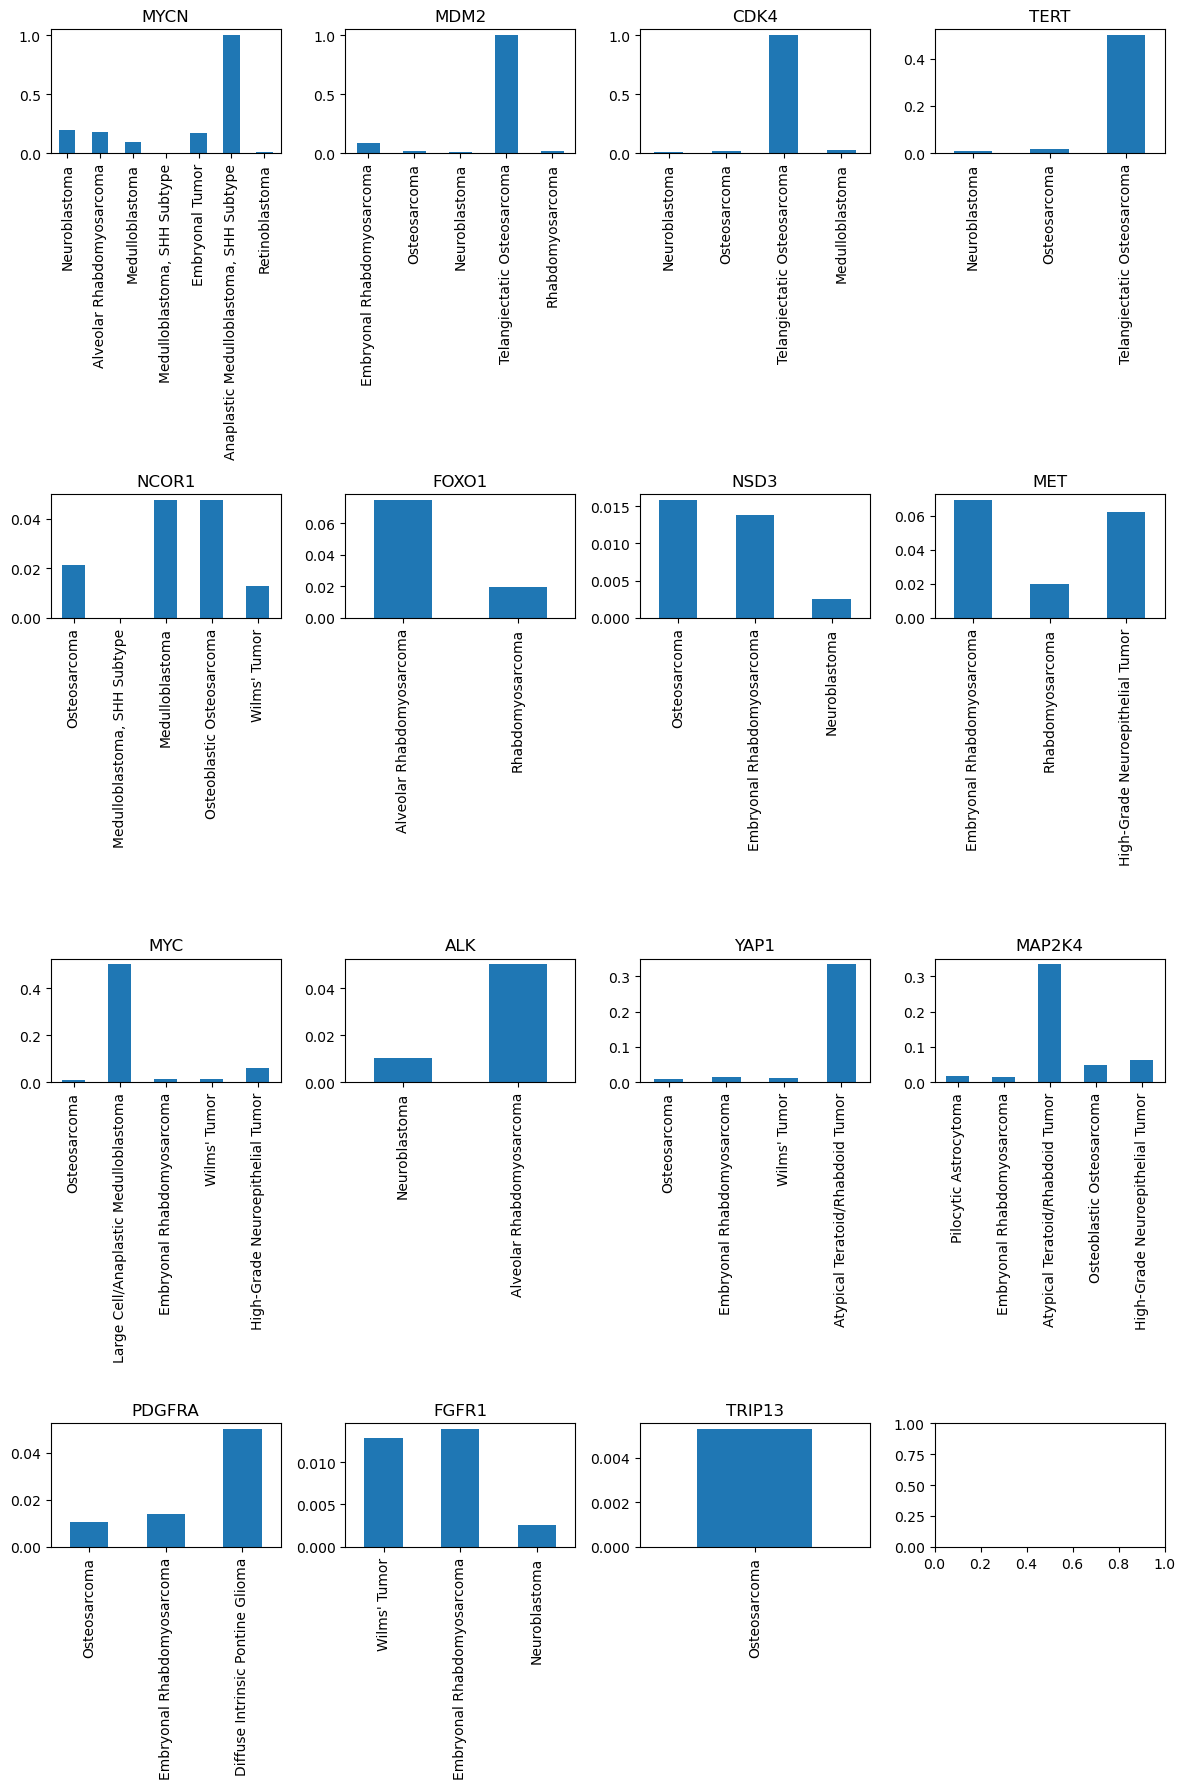

In [46]:
cancerCounts = {}
for i, row in ecDNA_patient.iterrows() :
        if row[analysis_type] in cancerCounts :
                cancerCounts[row[analysis_type]] += 1
        else :
                cancerCounts[row[analysis_type]] = 1

fig, axs = plt.subplots((len(gene_ecDNA_top15)+3)//4, 4, figsize = (12, 1.2 * len(gene_ecDNA_top15)))
axs = axs.flatten()

for i, gene in enumerate(gene_ecDNA_top15) :
        subset = echo[echo['gene'] == gene]
        subset = subset[subset['ecDNA_status'] == 'ecDNA']
        
        counts = subset[analysis_type].value_counts()
        counts = counts / counts.index.map(cancerCounts)
        counts.plot(kind = 'bar', ax = axs[i])
        axs[i].set_title(gene)
        axs[i].set_xlabel('')
fig.tight_layout()



Genes for specific cancers

In [47]:
ctype_dicts = []
ctype_non_dicts = []
cancers_with_ecDNA = []
for ctype in cancer_types :
    ctype_dict = {}
    ctype_non_dict = {}
    for i, row in echo.iterrows() :
        if row[analysis_type] == ctype :
            if row['ecDNA_status'] == 'ecDNA' :
                if isinstance(row['gene'], str) :
                    if not row['gene'] in ctype_dict :
                        ctype_dict[row['gene']] = 1
                    else :
                        ctype_dict[row['gene']] += 1
            if row['ecDNA_status'] == 'non-ecDNA' :
                if isinstance(row['gene'], str) :
                    if not row['gene'] in ctype_non_dict :
                        ctype_non_dict[row['gene']] = 1
                    else :
                        ctype_non_dict[row['gene']] += 1
    if len(ctype_dict) > 0 :
        ctype_dicts.append(ctype_dict)
        ctype_non_dicts.append(ctype_non_dict)
        cancers_with_ecDNA.append(ctype)

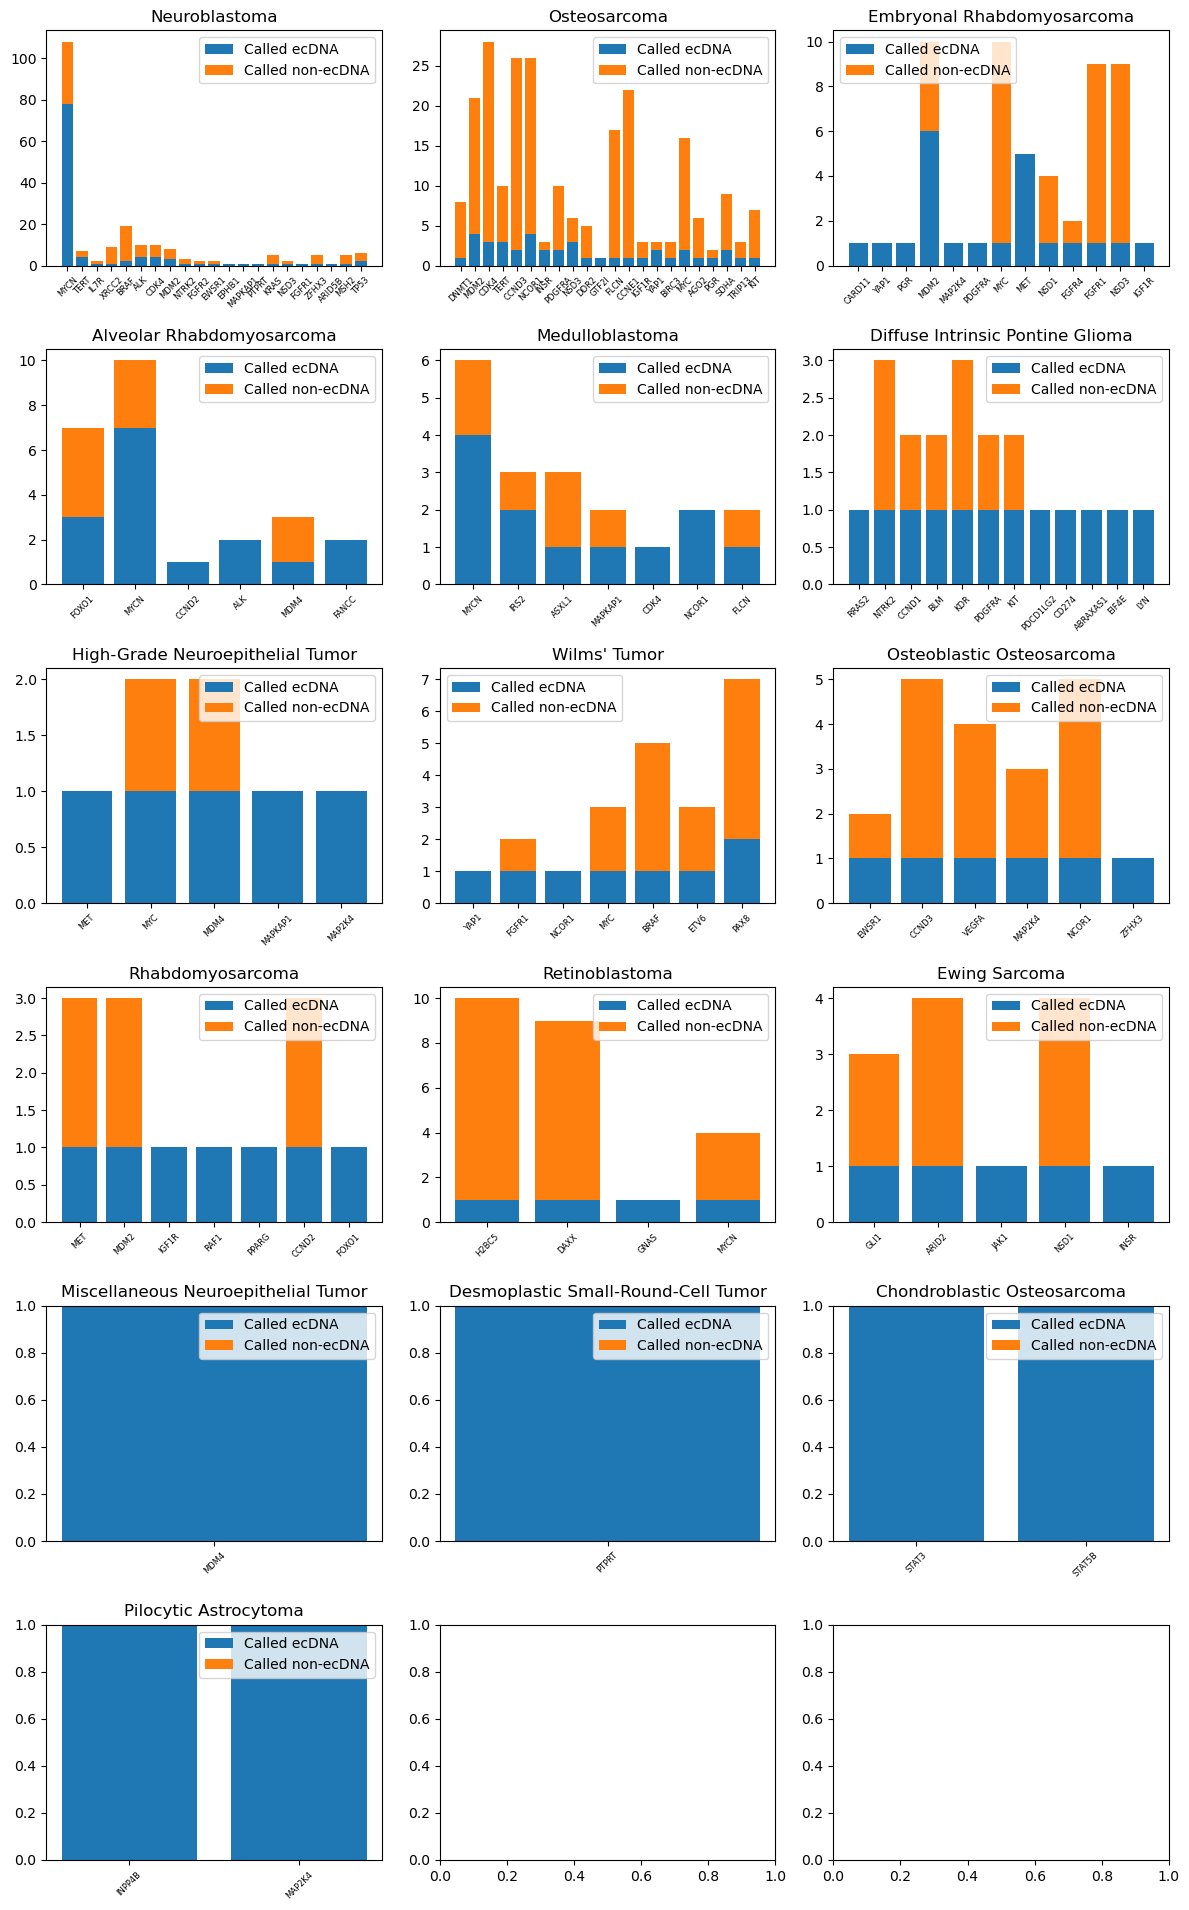

In [48]:
fig, axs = plt.subplots((len(cancers_with_ecDNA)+2)//3, 3, figsize = (12, 1.2 * len(cancers_with_ecDNA)))
axs = axs.flatten()

for i, ctype in enumerate(cancers_with_ecDNA) :
        labels = list(ctype_dicts[i].keys())
        values_dict1 = [ctype_dicts[i].get(label, 0) for label in labels]
        values_dict2 = [ctype_non_dicts[i].get(label, 0) for label in labels]
        axs[i].bar(labels, values_dict1)
        axs[i].bar(labels, values_dict2, bottom = values_dict1)

        axs[i].set_title(ctype)
        axs[i].set_xticklabels(labels, rotation=45, fontsize=6)
        axs[i].set_xlabel('')
        axs[i].legend((p1[0], p2[0]), ('Called ecDNA', 'Called non-ecDNA'))

fig.tight_layout()



In [49]:
cancers_with_ecDNA

['Neuroblastoma',
 'Osteosarcoma',
 'Embryonal Rhabdomyosarcoma',
 'Alveolar Rhabdomyosarcoma',
 'Medulloblastoma',
 'Diffuse Intrinsic Pontine Glioma',
 'High-Grade Neuroepithelial Tumor',
 "Wilms' Tumor",
 'Osteoblastic Osteosarcoma',
 'Rhabdomyosarcoma',
 'Retinoblastoma',
 'Ewing Sarcoma',
 'Miscellaneous Neuroepithelial Tumor',
 'Desmoplastic Small-Round-Cell Tumor',
 'Chondroblastic Osteosarcoma',
 'Pilocytic Astrocytoma']

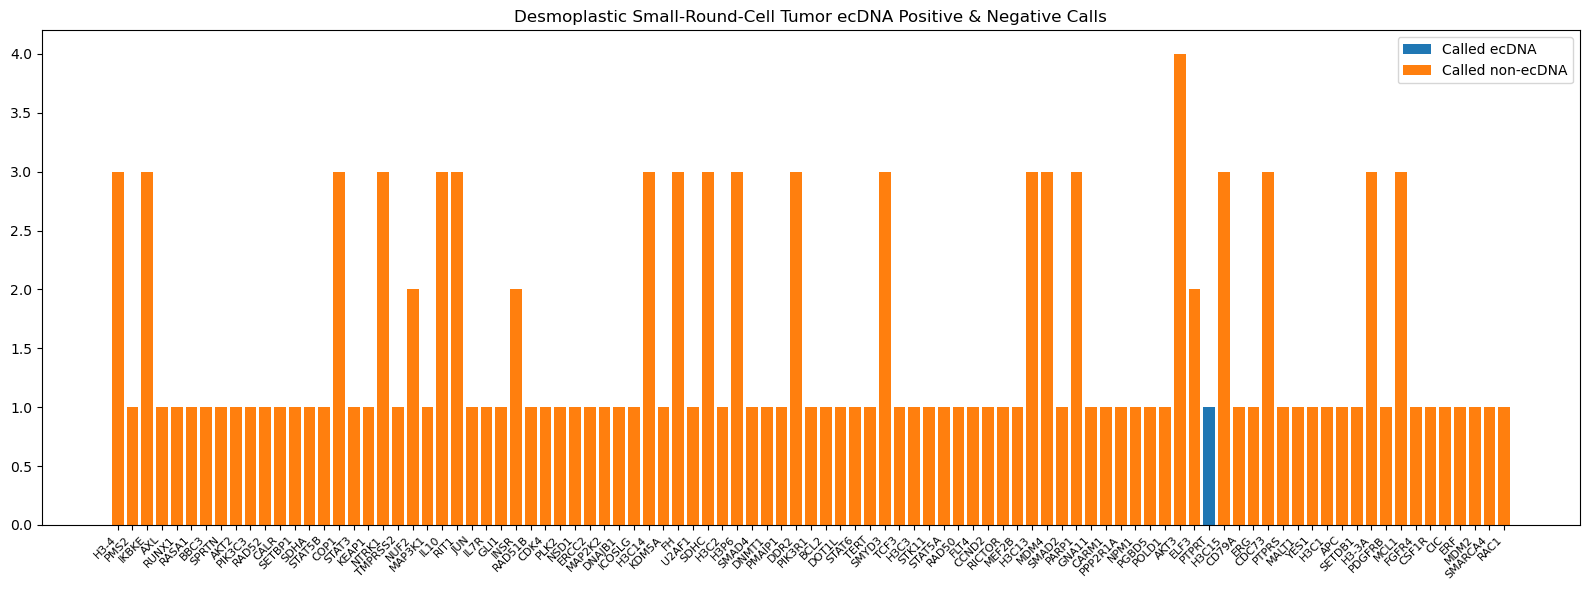

In [50]:
plt.figure(figsize=(16, 6))

for ctype in ['Desmoplastic Small-Round-Cell Tumor'] :
        i = 13
        labels = list((set(ctype_dicts[i].keys())).union(set(ctype_non_dicts[i].keys())))
        values_dict1 = [ctype_dicts[i].get(label, 0) for label in labels]
        values_dict2 = [ctype_non_dicts[i].get(label, 0) for label in labels]
        plt.bar(labels, values_dict1)
        plt.bar(labels, values_dict2, bottom = values_dict1)

        plt.title(f"{ctype} ecDNA Positive & Negative Calls")
        plt.xticks(rotation=45, ha = "right", fontsize=8)
        plt.xlabel('')
        plt.legend((p1[0], p2[0]), ('Called ecDNA', 'Called non-ecDNA'))

plt.tight_layout()
plt.savefig('dsrct.png')


### Segment Size from FACETS Results

In [51]:
facets_seq_length = facets.dropna(subset = ['seg_length'])

# Build a dictionary for ecDNA
ecDNA_gene_dict = {}
for i, row in echo.iterrows() :
    if row['ecDNA_status'] == 'ecDNA' :
        to_hash = row['tumorSampleId'] + '_' + row['gene']
        ecDNA_gene_dict[to_hash] = True

# Fill in facets column
facets_seq_length['ecDNA'] = 'non-ecDNA'
facets_seq_length['amped'] = False

for i, row in facets_seq_length.iterrows() :
    to_hash = row['sample'] + '_' + row['gene']
    if to_hash in ecDNA_gene_dict :
        facets_seq_length.loc[i, 'ecDNA'] = 'ecDNA'
    if "AMP" in row['cn_state'] or "GAIN" in row['cn_state'] :
        facets_seq_length.loc[i, 'amped'] = True


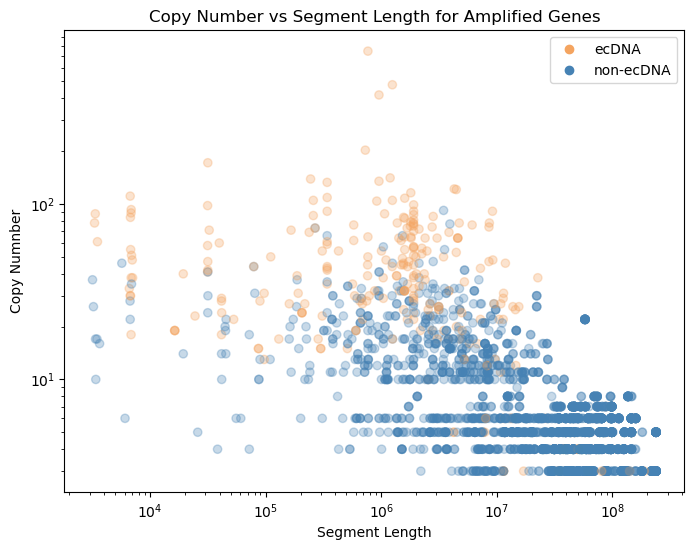

In [52]:
facets_amp = facets_seq_length[facets_seq_length['amped'] == True]

# Define colors for each category
color_map = {'ecDNA': 'sandybrown', 'non-ecDNA': 'steelblue'}

# Create a list of colors based on the 'ecDNA' column
colors = facets_amp['ecDNA'].map(color_map)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(facets_amp['seg_length'], facets_amp['tcn'], c=colors, label=facets_amp['ecDNA'], alpha = 0.3)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Copy Numnber')
plt.xlabel('Segment Length')
plt.title("Copy Number vs Segment Length for Amplified Genes")

legend_labels = ['ecDNA', 'non-ecDNA']
legend_colors = ['sandybrown', 'steelblue']
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in legend_colors]
plt.legend(markers, legend_labels, loc='upper right')

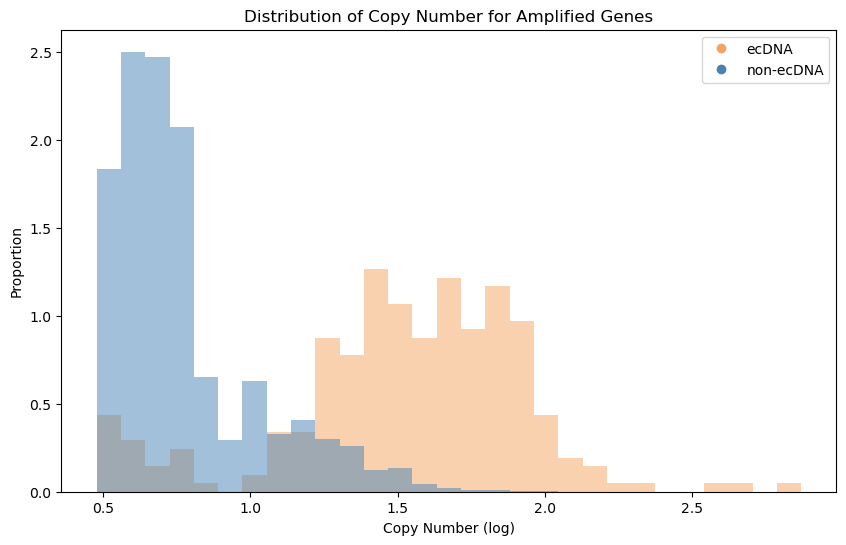

In [53]:
# Separate data for ecDNA and non-ecDNA
ecDNA_facets_amp = facets_amp[facets_amp['ecDNA'] == 'ecDNA']['tcn']
log_ecDNA = [math.log10(x) for x in ecDNA_facets_amp]

non_ecDNA_facets_amp = facets_amp[facets_amp['ecDNA'] == 'non-ecDNA']['tcn']
log_non_ecDNA = [math.log10(x) for x in non_ecDNA_facets_amp]

# Plotting histograms on logarithmic scale
plt.figure(figsize=(10, 6))
bins = np.linspace(min(log_ecDNA + log_non_ecDNA), max(log_ecDNA + log_non_ecDNA),30)
# Histogram for ecDNA = ecDNA
plt.hist(log_ecDNA, alpha=0.5, bins = bins, color='sandybrown', label='ecDNA', density = True)

# Histogram for ecDNA = non-ecDNA
plt.hist(log_non_ecDNA,  alpha=0.5, bins = bins, color='steelblue', label='non-ecDNA', density = True)

# Customize the plot
plt.title('Distribution of Copy Number for Amplified Genes')
plt.xlabel('Copy Number (log)')
plt.ylabel('Proportion')

legend_labels = ['ecDNA', 'non-ecDNA']
legend_colors = ['sandybrown', 'steelblue']
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in legend_colors]
plt.legend(markers, legend_labels, loc='upper right')


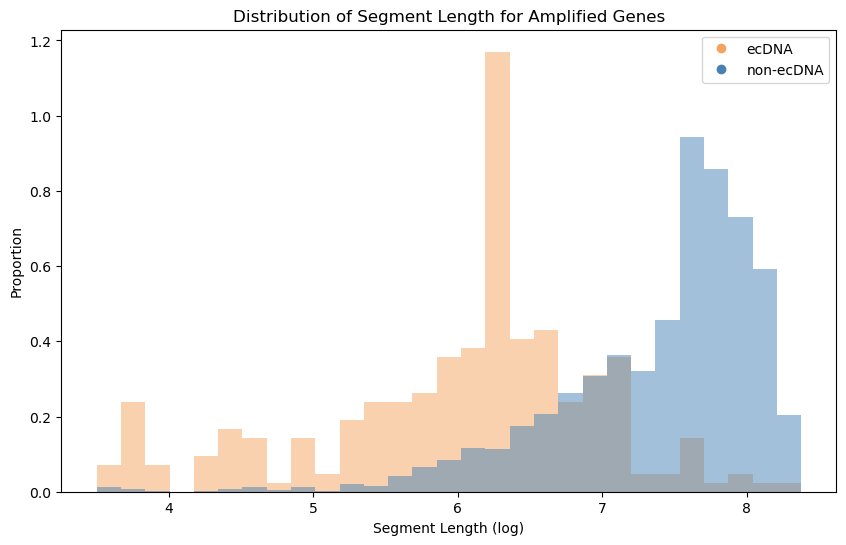

In [54]:
# Separate data for ecDNA and non-ecDNA
ecDNA_facets_amp = facets_amp[facets_amp['ecDNA'] == 'ecDNA']['seg_length']
log_ecDNA = [math.log10(x) for x in ecDNA_facets_amp]

non_ecDNA_facets_amp = facets_amp[facets_amp['ecDNA'] == 'non-ecDNA']['seg_length']
log_non_ecDNA = [math.log10(x) for x in non_ecDNA_facets_amp]

# Plotting histograms on logarithmic scale
plt.figure(figsize=(10, 6))
bins = np.linspace(min(log_ecDNA + log_non_ecDNA), max(log_ecDNA + log_non_ecDNA),30)
# Histogram for ecDNA = ecDNA
plt.hist(log_ecDNA, alpha=0.5, bins = bins, color='sandybrown', label='ecDNA', density = True)

# Histogram for ecDNA = non-ecDNA
plt.hist(log_non_ecDNA,  alpha=0.5, bins = bins, color='steelblue', label='non-ecDNA', density = True)

# Customize the plot
plt.title('Distribution of Segment Length for Amplified Genes')
plt.xlabel('Segment Length (log)')
plt.ylabel('Proportion')

legend_labels = ['ecDNA', 'non-ecDNA']
legend_colors = ['sandybrown', 'steelblue']
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in legend_colors]
plt.legend(markers, legend_labels, loc='upper right')

### ecDNA Co-occurance

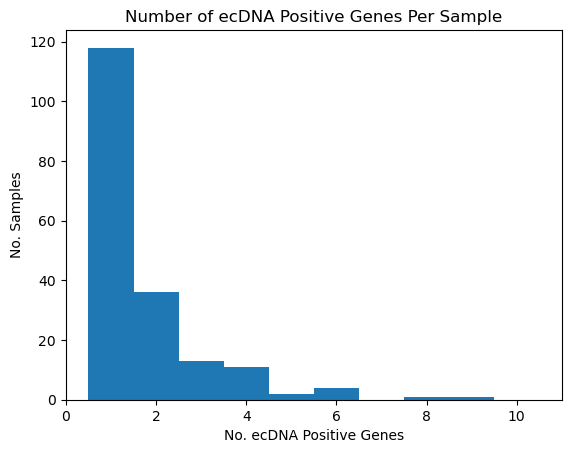

In [58]:
# Dict of ecDNA counts
ecDNA_count_per_patient = {}
for i, row in echo.iterrows() :
    if row['ecDNA_status'] == 'ecDNA' :
        if row['patientId'] in ecDNA_count_per_patient :
            ecDNA_count_per_patient[row['patientId']] += 1
        else :
            ecDNA_count_per_patient[row['patientId']] = 1

# Create a histogram
patient_counts = ecDNA_count_per_patient.values()
plt.hist(patient_counts, bins = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5])
plt.title("Number of ecDNA Positive Genes Per Sample")
plt.xlabel("No. ecDNA Positive Genes")
plt.ylabel("No. Samples")
plt.savefig("ecDNA_nums.png")